In [350]:
import sys
from typing import List, Dict, Tuple
from data_tools import task_map, row_operations
from utils import persistence as ps
from urllib3.response import HTTPResponse
from pandas import DataFrame, Series, read_csv, concat, Grouper, melt, merge_asof, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Process, cpu_count
from error_handling import errors
from scipy import stats
from geo_merger import geo_merge, EXT
from numpy import array, empty, float64, zeros_like, triu_indices_from, log, nan, inf, asarray
from time import sleep
from functools import reduce

In [351]:
import warnings
warnings.filterwarnings('ignore')

In [352]:
RGTRANSIT_BUCKET: str = 'rg-transit'
RGFARES_BUCKET: str = 'rg-tsfare'
RGGCABS_BUCKET: str = 'rg-gcabs'
RGYCABS_BUCKET: str = 'rg-ycabs'
RGTRAFFIC_BUCKET: str = 'rg-traffic'
REFBASE_BUCKET: str = 'ref-base'
GEOMERGED_PATH: str = 'geo-merged/'
PLOTS_BUCKET: str = 'plots'

MIN_INVW= 1 / 9.5
MAX_INVW = 1 / 0.5
RELPLOT_SZ_MULT = 1.5

BASE_COLOR='#34495E'
COLOR1='#E74C3C'
COLOR2='#2ECC71'

In [353]:
station_complex_map: Dict[str, str] = {
                                'BOWERY': 'BOWERY STREET-DELANCEY ST',
                                'WALL ST': 'WALL STREET',
                                'COURT SQ': 'COURT SQ',
                                '86 ST': '86TH STREET-4TH AVENUE',
                                'SOUTH FERRY': 'WHITEHALL STREET'
                              }
station_map: Dict[str, int] = {
                                'BOWERY': 103,
                                'WALL ST': 413,
                                'COURT SQ': 274,
                                '86 ST': 397,
                                'SOUTH FERRY': 330
                              }
weekday_map: Dict[int, str] = {
                                0 : 'Monday',
                                1 : 'Tuesday',
                                2 : 'Wednesday',
                                3 : 'Thursday',
                                4 : 'Friday',
                                5 : 'Saturday',
                                6 : 'Sunday'
                              }


In [354]:
geomerged_cabs: str = GEOMERGED_PATH+'/cabs.csv'
geomerged_traffic: str = GEOMERGED_PATH+'/traffic.csv'

# load ref-base geomerged files
filestream: HTTPResponse = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_cabs)
dtypes: Dict[str, str] = {
    'stop_name': 'object',
    'tsstation': 'object',
    'locationid': 'int64',
    'weight': 'float64'
}
geomerged_cabs_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_cabs_df = geomerged_cabs_df[~geomerged_cabs_df['locationid'].isna()]
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_traffic)
dtypes = {
    'stop_name': 'object',
    'tsstation': 'object',
    'linkid': 'float64',
    'weight': 'float64'
}
geomerged_traffic_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_traffic_df = geomerged_traffic_df[~geomerged_traffic_df['linkid'].isna()]

In [355]:
task = 'pl-1W-16-17'
freq = '1D'
filterby ='all'
filterval = ''
stations = ['BOWERY', 'WALL ST', 'COURT SQ', '86 ST', 'SOUTH FERRY']
station = stations[0]

In [356]:
range_: List[str] = task_map.task_type_map[task]['range']
start_date: str = range_[0]
end_date: str = range_[1]
# determine filename of transit data for
# the current station in the rg-transit bucket
# replace '/' in station with ' '
file_path: str = freq+'/'+filterby+filterval+'/'
ts_filename: str = file_path+station.replace('/', ' ').upper()

# read transit data for station (rg-transit bucket)
filestream = ps.get_file_stream(bucket=RGTRANSIT_BUCKET, filename=ts_filename)
ts_datecols = ['datetime']
dtypes = {
         'delex': 'int64',
         'delent': 'int64'
        }
transit_df = read_csv(filestream, usecols=ts_datecols + list(dtypes.keys()),
                                 parse_dates=ts_datecols,
                                 date_parser=row_operations.parse_rg_dt,
                                 encoding='utf-8', dtype=dtypes)
transit_df = transit_df.set_index('datetime').resample(freq).sum().loc[start_date: end_date]
transit_df.head()

,delex,delent
datetime,,
2016-01-01,3059,3133
2016-01-02,2980,2780
2016-01-03,2374,3051
2016-01-04,2353,3017
2016-01-05,2093,3020


In [357]:
def weighted_mean(group, weight_col):
    data_cols = [col for col in group.columns if col != weight_col]
    group_result = Series(empty(len(data_cols)), index=data_cols, dtype=float64)
    total_weight = group[weight_col].sum()
    for col in data_cols:
        group_result[col] = (group[col] * group[weight_col]).sum() / total_weight
    return group_result

In [358]:
cabs_datecols = ['dodatetime']

# determine relevant cabs files
# by finding dolocationids corresponding
# to current station from ref-base geomerged df
dolocationids = geomerged_cabs_df.loc[geomerged_cabs_df.tsstation == station][['locationid', 'weight']]

cabs_dtypes = {
    'dolocationid': 'int64',
    'passengers': 'int64',
    'distance': 'float64'
}

gcabs_df: DataFrame
gcabs_df = concat([read_csv(ps.get_file_stream(bucket=RGGCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGGCABS_BUCKET, path=file_path)],
                   ignore_index=True)
gcabs_df = gcabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left', copy=False).\
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()

#gcabs_df = gcabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#
gcabs_df = gcabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]
gcabs_df.head()

,passengers,distance
dodatetime,,
2016-01-01,12.056009,26.380658
2016-01-02,11.237360,22.749472
2016-01-03,10.663044,22.722072
2016-01-04,11.985014,22.105446
2016-01-05,11.504679,21.782566


In [359]:
ycabs_df: DataFrame
ycabs_df = concat([read_csv(ps.get_file_stream(bucket=RGYCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGYCABS_BUCKET, path=file_path)],
                  ignore_index=True)
ycabs_df = ycabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left',
                          copy=False). \
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()
#ycabs_df = ycabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq='D', level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#                                                                                                 'weight': 'first'}).loc[
#           start_date: end_date]
ycabs_df = ycabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

ycabs_df.head()

,passengers,distance
dodatetime,,
2016-01-01,32.533841,72.170801
2016-01-02,40.895144,88.219552
2016-01-03,37.612326,90.522941
2016-01-04,42.976396,2057.190921
2016-01-05,44.490666,208.194280


In [360]:
traffic_df: DataFrame
traffic_datecols = ['datetime']
linkids = geomerged_traffic_df.loc[geomerged_traffic_df.tsstation == station][['linkid', 'weight']]

if linkids.size > 0:
    traffic_dtypes = {
        'linkid': 'int64',
        'speed': 'float64',
        'traveltime': 'float64'
    }
    traffic_cols = list(traffic_dtypes.keys())
    traffic_df = concat([read_csv(ps.get_file_stream(bucket=RGTRAFFIC_BUCKET, filename=file_path+str(int(linkid))),
                                  header=0,
                                  usecols=traffic_datecols + traffic_cols,
                                  parse_dates=traffic_datecols,
                                  encoding='utf-8', dtype=traffic_dtypes)
                        for linkid in linkids['linkid']
                       if str(int(linkid)) in ps.get_all_filenames(bucket=RGTRAFFIC_BUCKET, path=file_path)],
                      ignore_index=True)
    traffic_df = traffic_df.merge(linkids, on='linkid', how='left', copy=False).drop(columns=['linkid']).drop_duplicates()
    #traffic_df = traffic_df.set_index(traffic_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'speed': 'mean',
    #                                                                                                'traveltime': 'mean',
    #
    traffic_df = traffic_df.set_index(traffic_datecols).groupby(Grouper(freq=freq, level=0)).\
                apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

traffic_df.head()

,speed,traveltime
datetime,,
2016-01-01,46.992075,140.999960
2016-01-02,44.709208,155.253829
2016-01-03,45.518173,155.956252
2016-01-04,40.980257,181.892347
2016-01-05,40.434037,189.558958


In [361]:
# gas
gas_file: str ='gas.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=gas_file)
dtypes = {
    'price': 'float64'
}
gas_datecols = ['date']
gas_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+gas_datecols, parse_dates=gas_datecols, encoding='utf-8', dtype=dtypes)
gas_df = gas_df.set_index(gas_datecols).loc[start_date: end_date]
# drop outliers
gas_df = row_operations.drop_outliers(gas_df, 'price')
# gas data is weekly reported on Mondays
# shift dates from Monday to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
# shift back by one day
#td = Timedelta(-1, unit='d')
#gas_df.index = gas_df.index + td
gas_df.head()

,price
date,
2016-01-04,2.147
2016-01-11,2.123
2016-01-18,2.056
2016-01-25,2.027
2016-02-01,1.997


In [362]:
ix = DatetimeIndex(start=start_date, end=end_date, freq='D')
gas_df = gas_df.reindex(ix).interpolate(method='linear', limit_direction='both')
gas_df.head()

,price
2016-01-01,2.147000
2016-01-02,2.147000
2016-01-03,2.147000
2016-01-04,2.147000
2016-01-05,2.143571


In [363]:
# weather
weather_file: str ='weather.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=weather_file)
dtypes = {
        'prcp': 'float64',
        'snow': 'float64',
        'temp': 'float64'
}
weather_datecols = ['date']
weather_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+weather_datecols, parse_dates=weather_datecols, encoding='utf-8', dtype=dtypes)
weather_df = weather_df.set_index(weather_datecols).loc[start_date: end_date]
# weather data is daily
# filter by day (filterby and filterval)
#print(filterval)
#weather_df = weather_df.loc[weather_df.index.dayofweek == int(filterval)]
# shift dates from filterval day to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
#td = Timedelta(-1-int(filterval), unit='d')
#weather_df.index = weather_df.index + td
weather_df.head()

,prcp,snow,temp
date,,,
2016-01-01,0.0,0.0,38.0
2016-01-02,0.0,0.0,36.0
2016-01-03,0.0,0.0,40.0
2016-01-04,0.0,0.0,25.0
2016-01-05,0.0,0.0,20.0


In [364]:
cabs_df= DataFrame()
cabs_df['passengers'] = gcabs_df['passengers'] + ycabs_df['passengers']
cabs_df['distance'] = gcabs_df['distance'] + ycabs_df['distance']

In [365]:
df_merged = concat([transit_df, cabs_df, traffic_df, gas_df, weather_df], axis=1)
df_merged.head()

,delex,delent,passengers,distance,speed,traveltime,price,prcp,snow,temp
2016-01-01,3059.0,3133.0,44.589850,98.551459,46.992075,140.999960,2.147000,0.0,0.0,38.0
2016-01-02,2980.0,2780.0,52.132504,110.969024,44.709208,155.253829,2.147000,0.0,0.0,36.0
2016-01-03,2374.0,3051.0,48.275369,113.245013,45.518173,155.956252,2.147000,0.0,0.0,40.0
2016-01-04,2353.0,3017.0,54.961410,2079.296367,40.980257,181.892347,2.147000,0.0,0.0,25.0
2016-01-05,2093.0,3020.0,55.995345,229.976845,40.434037,189.558958,2.143571,0.0,0.0,20.0


In [366]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 10 columns):
delex         729 non-null float64
delent        729 non-null float64
passengers    731 non-null float64
distance      731 non-null float64
speed         626 non-null float64
traveltime    626 non-null float64
price         731 non-null float64
prcp          731 non-null float64
snow          731 non-null float64
temp          731 non-null float64
dtypes: float64(10)
memory usage: 62.8 KB


In [367]:
len(df_merged.loc[df_merged.isna().any(axis=1).values])

107

In [368]:
#df_merged = df_merged.dropna()
df_merged = df_merged.interpolate(method='linear', limit_direction='both')
len(df_merged.loc[df_merged.isna().any(axis=1).values])

0

In [369]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 10 columns):
delex         731 non-null float64
delent        731 non-null float64
passengers    731 non-null float64
distance      731 non-null float64
speed         731 non-null float64
traveltime    731 non-null float64
price         731 non-null float64
prcp          731 non-null float64
snow          731 non-null float64
temp          731 non-null float64
dtypes: float64(10)
memory usage: 62.8 KB


#### Stationarity tests

In [370]:
sns.set_style('darkgrid')

In [371]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(15,6))
    orig = ax.plot(timeseries, color='blue',label='Original')
    mean = ax.plot(rolmean, color='red', label='Rolling Mean')
    std = ax.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [372]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [373]:
def make_acf_plot(series, lag=50):
    fig, ax = plt.subplots(2,1, figsize=(15,12))
    plot_acf(series, ax=ax[0], lags=lag)
    plot_pacf(series, ax=ax[1], lags=lag)
    plt.show()
    return

In [374]:
def make_hist_plot(series):
    fig, ax = plt.subplots(figsize=(15,6))
    hist = ax.hist(series, bins=50)
    plt.show()
    return    

In [375]:
def make_ts_plots(series, lag=50):
    test_stationarity(series)
    make_hist_plot(series)
    make_acf_plot(series, lag)
    return

### Transit Passengers (exiting the station)
#### This series is stationary

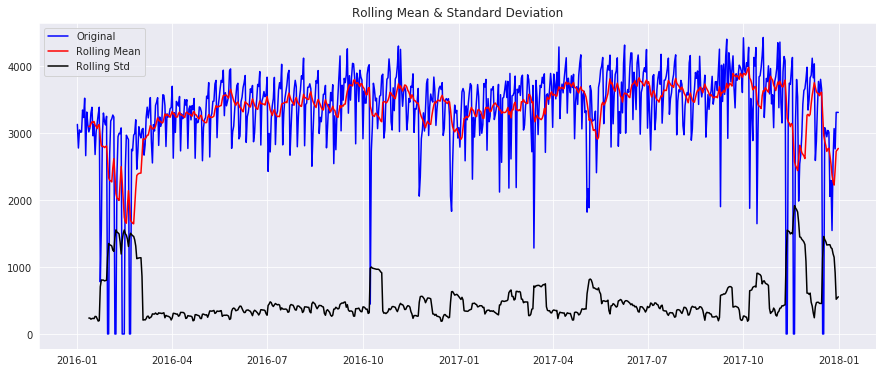

Results of Dickey-Fuller Test:
Test Statistic                  -3.206057
p-value                          0.019637
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


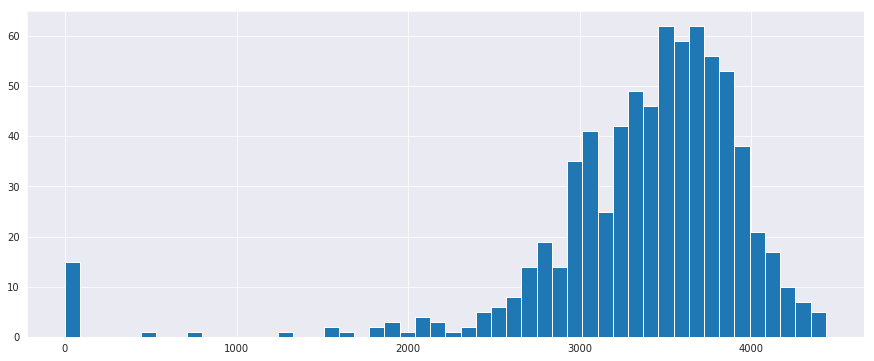

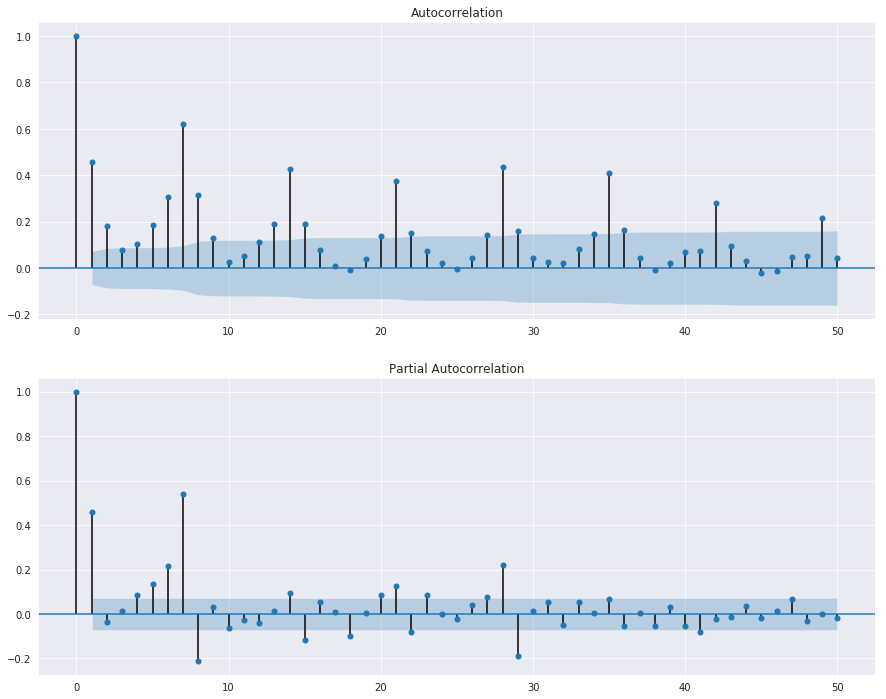

In [376]:
make_ts_plots(df_merged['delent'])

### Transit Passengers (entering the station)
#### This series is stationary

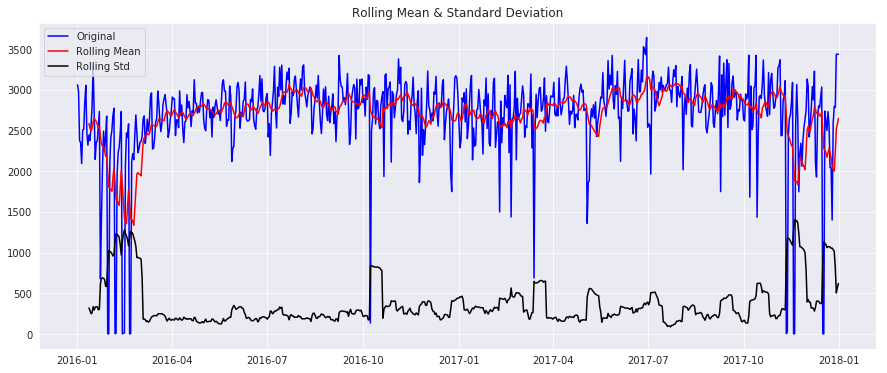

Results of Dickey-Fuller Test:
Test Statistic                  -4.136697
p-value                          0.000842
#Lags Used                       6.000000
Number of Observations Used    724.000000
Critical Value (1%)             -3.439414
Critical Value (5%)             -2.865540
Critical Value (10%)            -2.568900
dtype: float64


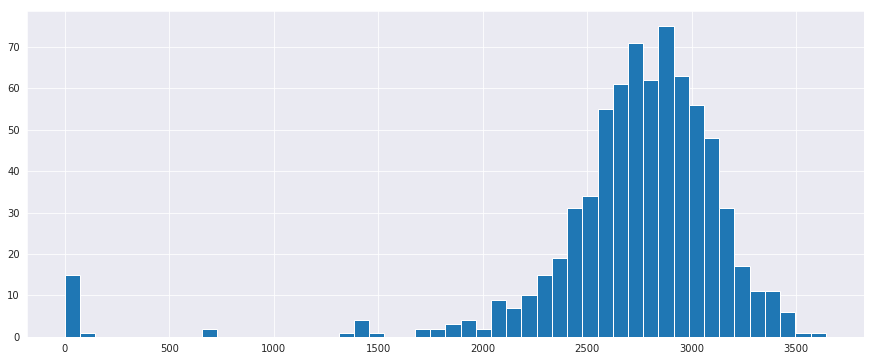

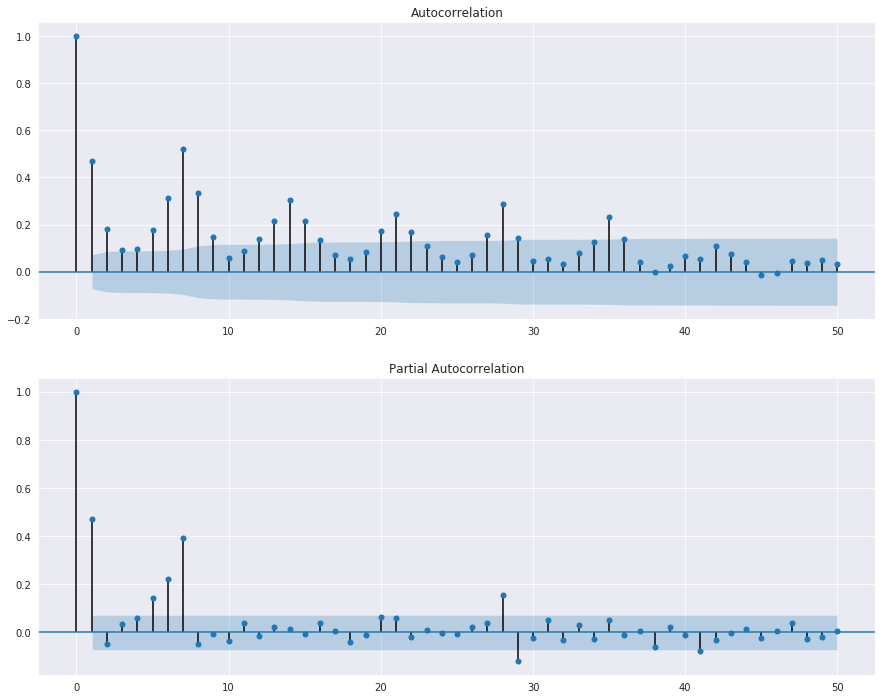

In [377]:
make_ts_plots(df_merged['delex'])

### Cab Rides
#### This series is non-stationary

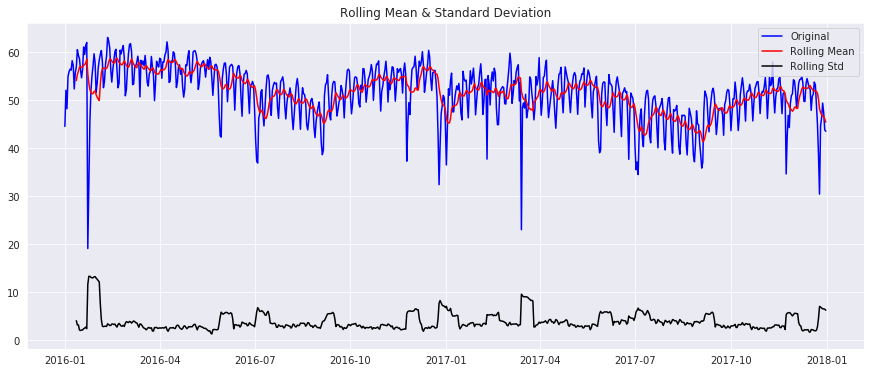

Results of Dickey-Fuller Test:
Test Statistic                  -2.496005
p-value                          0.116449
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


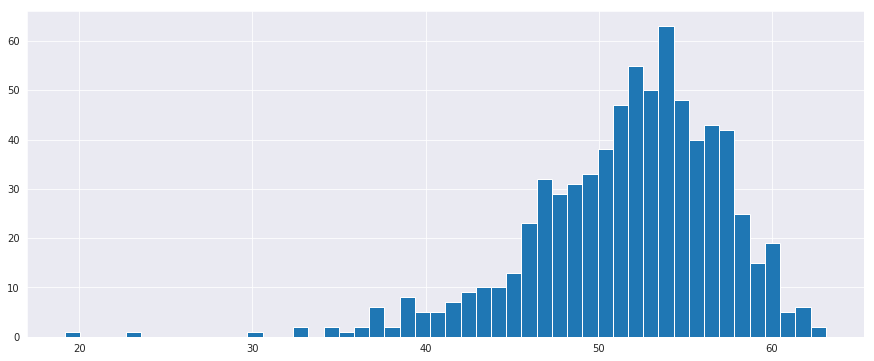

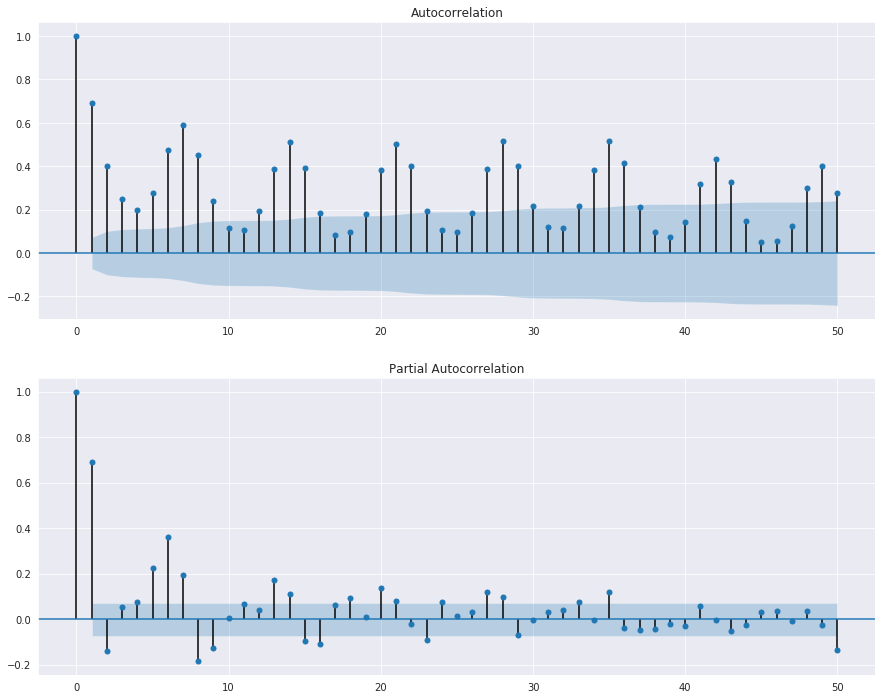

In [378]:
make_ts_plots(df_merged['passengers'])

### Traffic Speed
#### This series is non-stationary

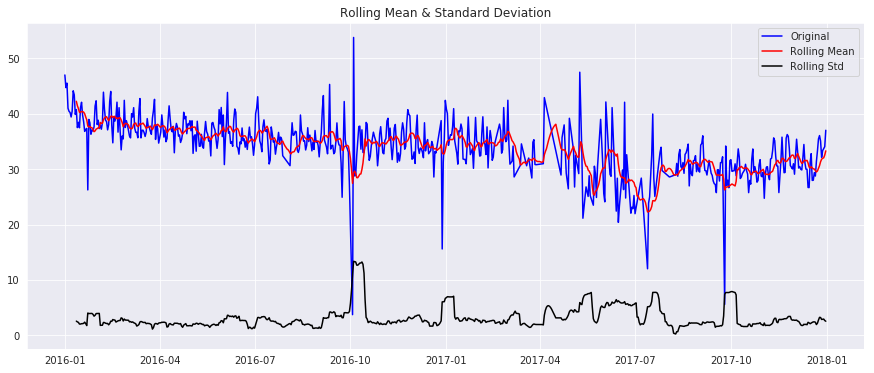

Results of Dickey-Fuller Test:
Test Statistic                  -3.247716
p-value                          0.017384
#Lags Used                      13.000000
Number of Observations Used    717.000000
Critical Value (1%)             -3.439503
Critical Value (5%)             -2.865579
Critical Value (10%)            -2.568921
dtype: float64


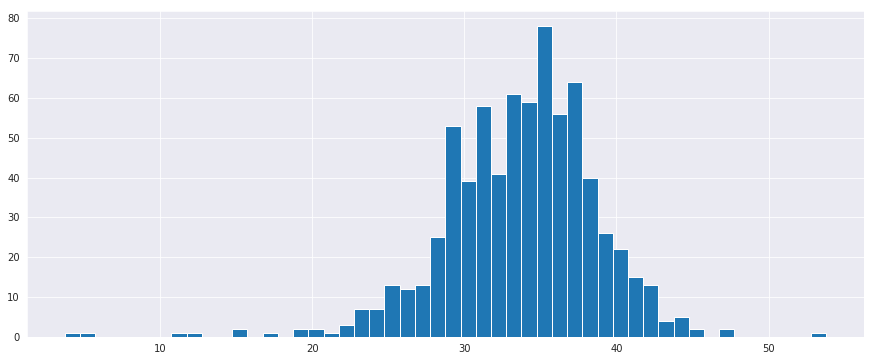

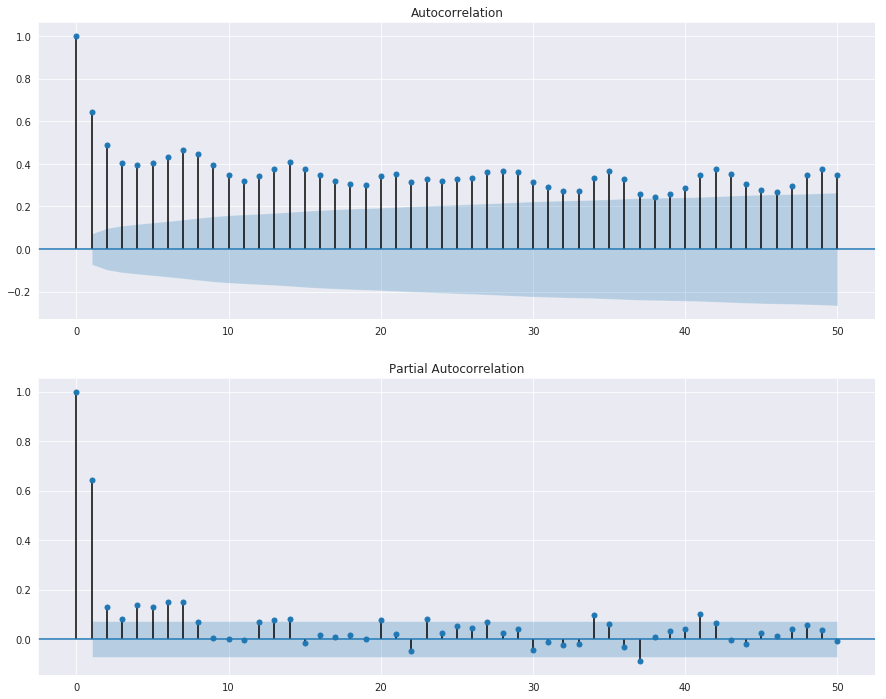

In [379]:
make_ts_plots(df_merged['speed'])

### Gas Price
#### This series is non-stationary

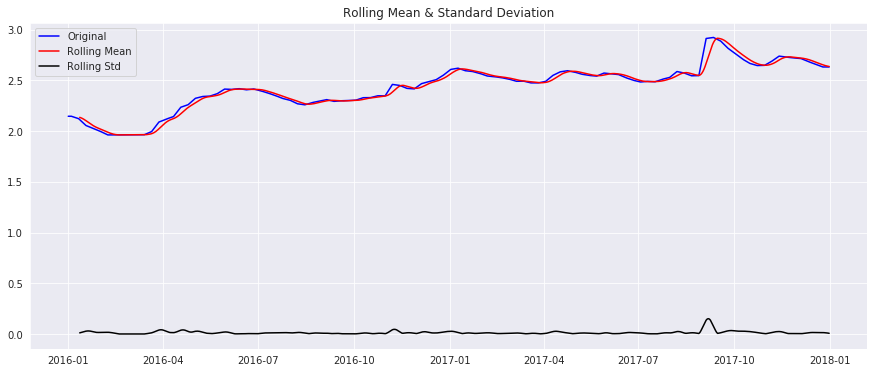

Results of Dickey-Fuller Test:
Test Statistic                  -1.954157
p-value                          0.307028
#Lags Used                      15.000000
Number of Observations Used    715.000000
Critical Value (1%)             -3.439529
Critical Value (5%)             -2.865591
Critical Value (10%)            -2.568927
dtype: float64


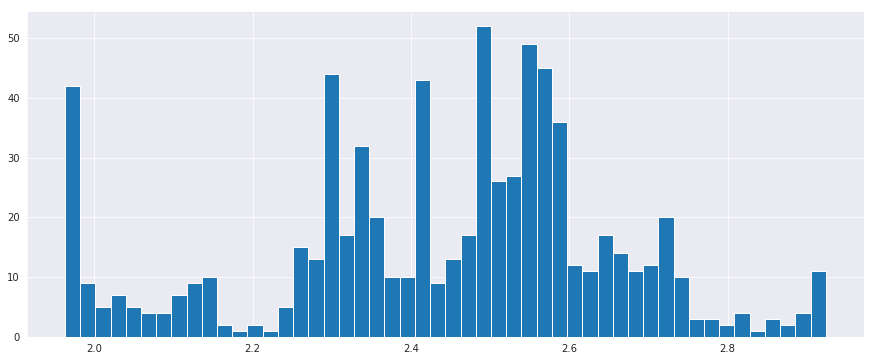

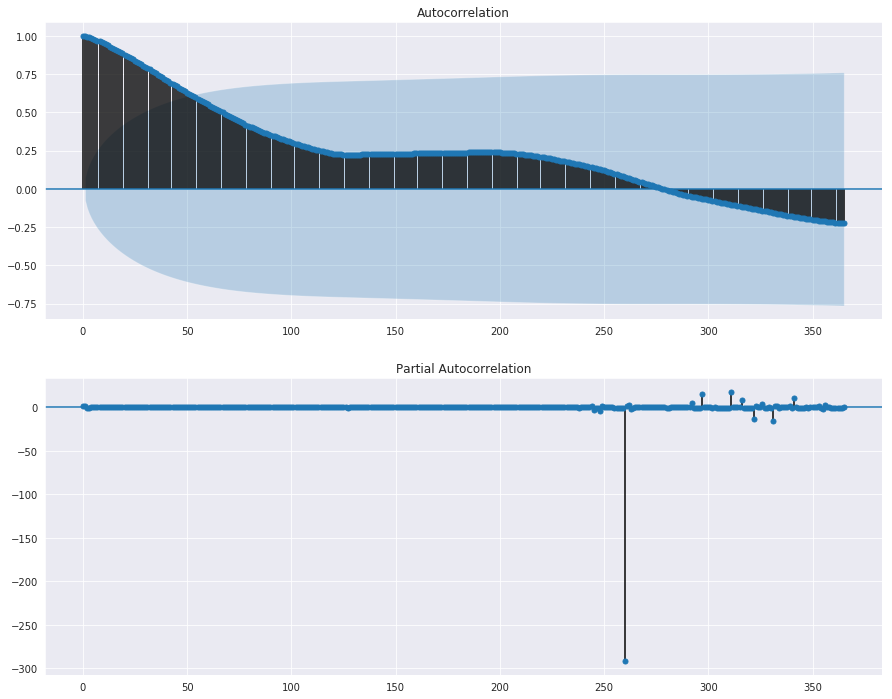

In [380]:
make_ts_plots(df_merged['price'], lag=365)

### Weather Temperature
#### This series is non-stationary

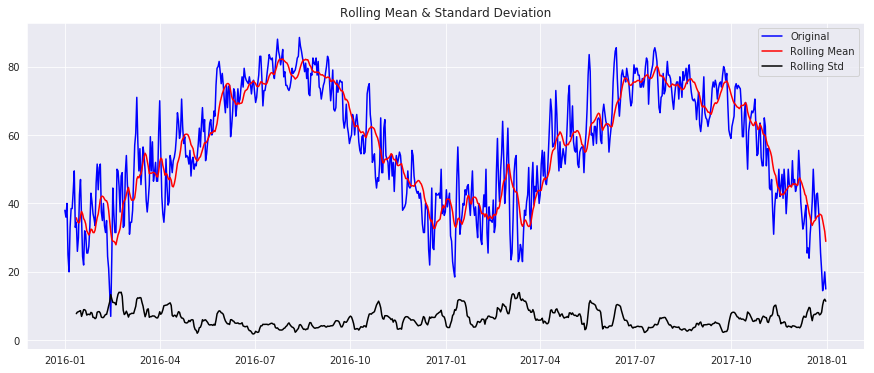

Results of Dickey-Fuller Test:
Test Statistic                  -1.220396
p-value                          0.664761
#Lags Used                      14.000000
Number of Observations Used    716.000000
Critical Value (1%)             -3.439516
Critical Value (5%)             -2.865585
Critical Value (10%)            -2.568924
dtype: float64


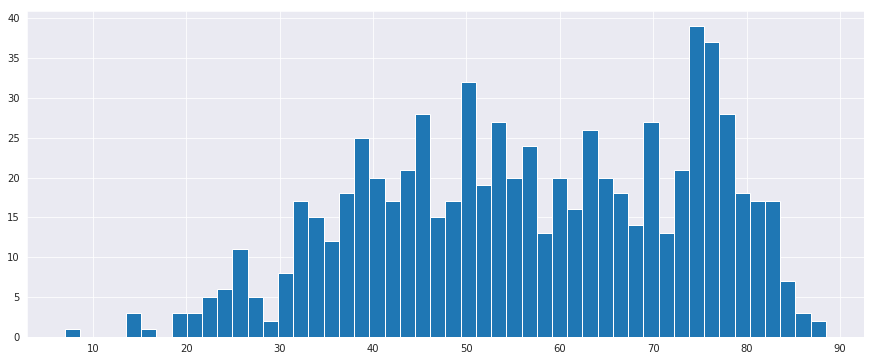

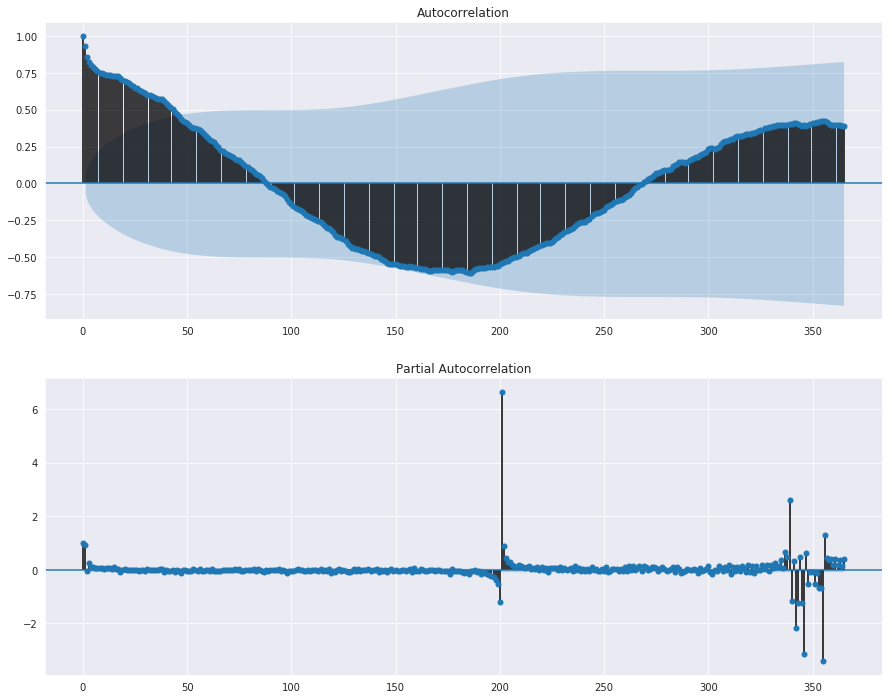

In [381]:
make_ts_plots(df_merged['temp'], lag=365)

### Transform each Series to make Stationary
#### (using log of difference with suitable time lag period for each series)

In [382]:
def smooth_log_diff(series, lag=1):
    series = log(series).diff(periods=lag)
    return series

In [383]:
def drop_inf_na(series):    
    series = series.replace([inf, -inf], nan).dropna()
    return series

In [384]:
from numpy import polyfit
def smooth_poly(series, degree=2):
    X = [i%365 for i in range(0, len(series))]
    y = series
    coef = polyfit(X, y, degree)
    y_hat = []
    for i in range(len(X)):
        value = coef[-1]
        for d in range(degree):
            value += X[i]**(degree-d) * coef[d]
        y_hat.append(value)
    values = series.values
    diff = []
    for i in range(len(values)):
        value = values[i] - y_hat[i]
        diff.append(value)
    return diff

### Transit Passengers (exiting the station)
#### lag = 7

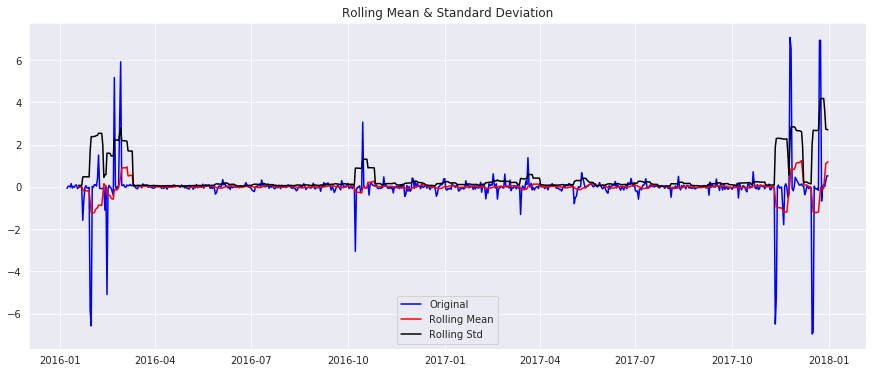

Results of Dickey-Fuller Test:
Test Statistic                -1.043005e+01
p-value                        1.619574e-18
#Lags Used                     2.000000e+01
Number of Observations Used    7.010000e+02
Critical Value (1%)           -3.439713e+00
Critical Value (5%)           -2.865672e+00
Critical Value (10%)          -2.568970e+00
dtype: float64


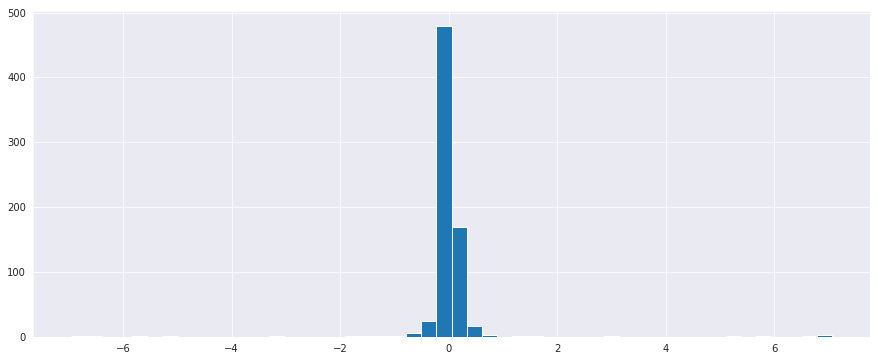

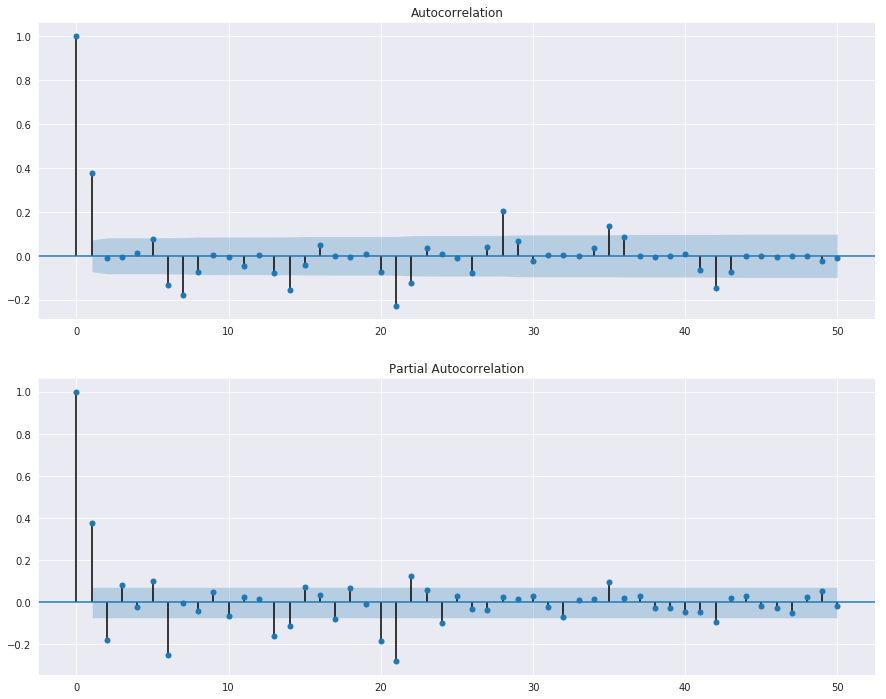

In [385]:
df_merged['delex_diff1'] = smooth_log_diff(df_merged['delex'], lag=7)
make_ts_plots(drop_inf_na(df_merged['delex_diff1']))

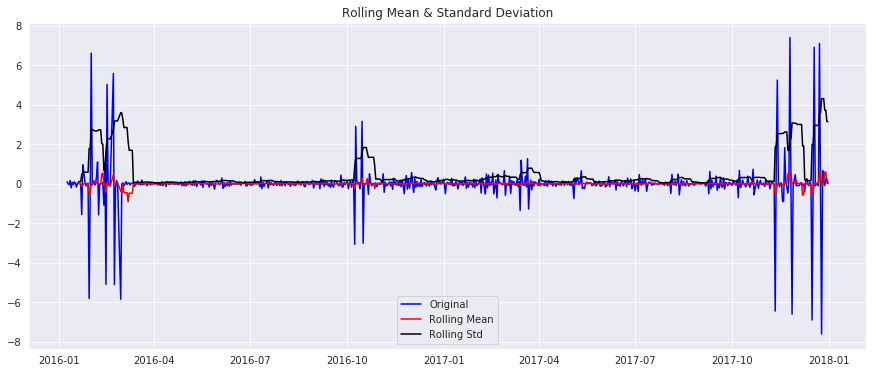

Results of Dickey-Fuller Test:
Test Statistic                -7.282894e+00
p-value                        1.484412e-10
#Lags Used                     2.000000e+01
Number of Observations Used    6.980000e+02
Critical Value (1%)           -3.439753e+00
Critical Value (5%)           -2.865690e+00
Critical Value (10%)          -2.568980e+00
dtype: float64


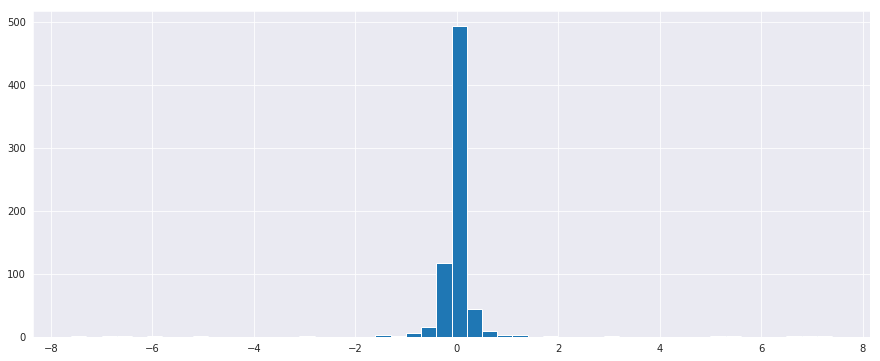

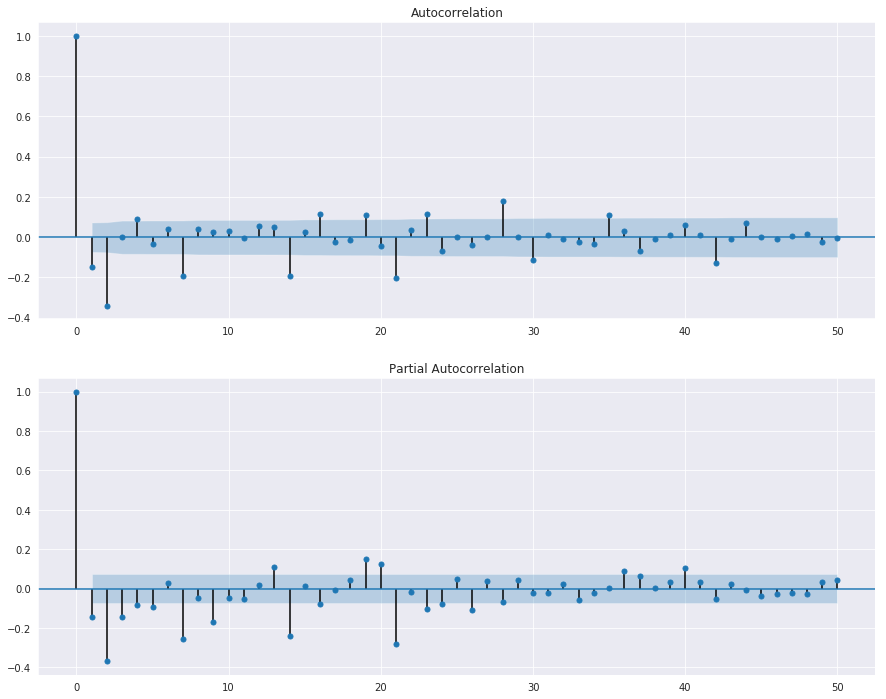

In [386]:
df_merged['delex_diff2'] = df_merged['delex_diff1'].diff()
make_ts_plots(drop_inf_na(df_merged['delex_diff2']))

### Transit Passengers (entering the station)
#### lag = 7

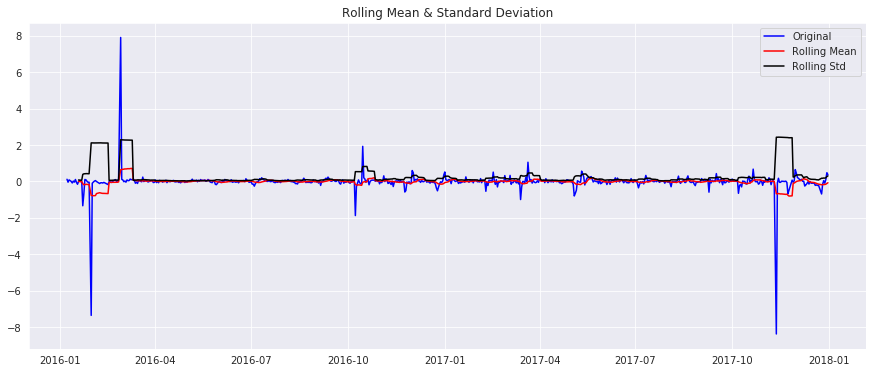

Results of Dickey-Fuller Test:
Test Statistic                -8.304607e+00
p-value                        3.934426e-13
#Lags Used                     1.800000e+01
Number of Observations Used    6.860000e+02
Critical Value (1%)           -3.439918e+00
Critical Value (5%)           -2.865762e+00
Critical Value (10%)          -2.569019e+00
dtype: float64


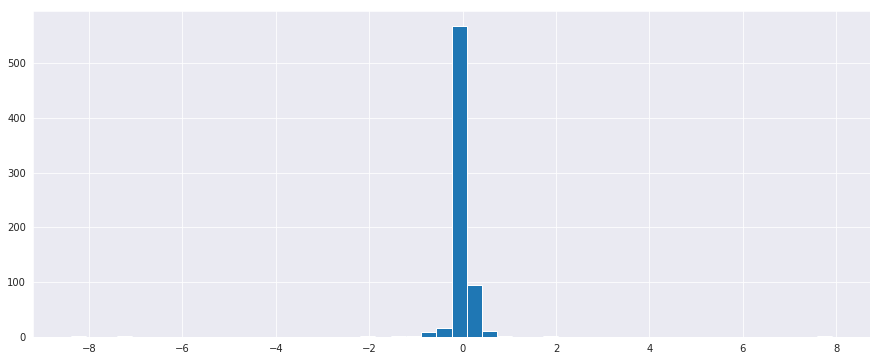

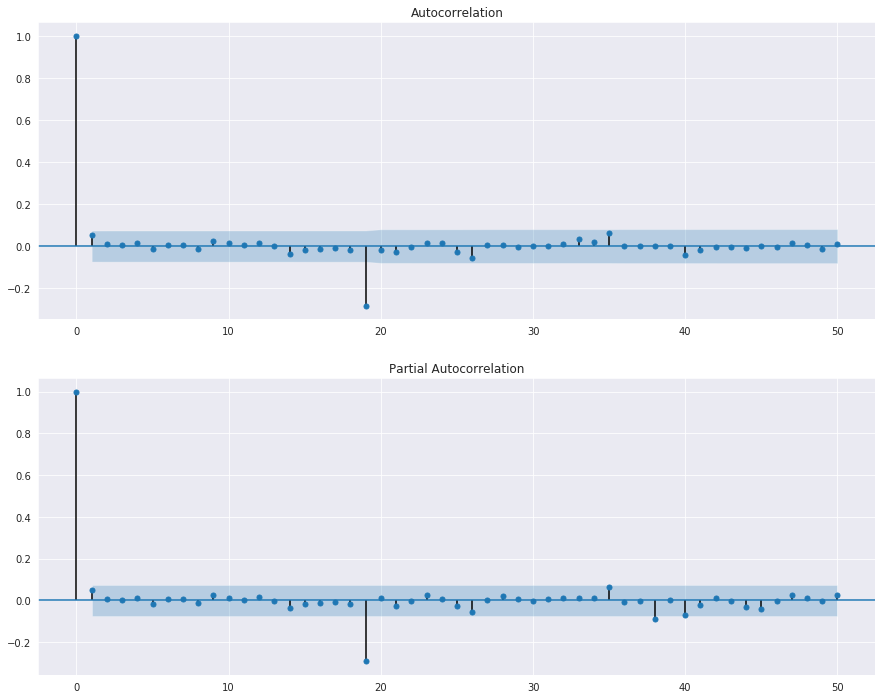

In [387]:
df_merged['delent_diff1'] = smooth_log_diff(df_merged['delent'], lag=7)
make_ts_plots(drop_inf_na(df_merged['delent_diff1']))

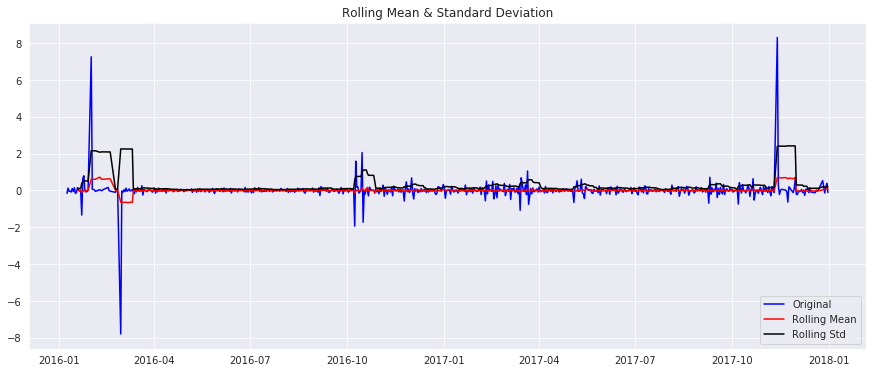

Results of Dickey-Fuller Test:
Test Statistic                -8.910021e+00
p-value                        1.110806e-14
#Lags Used                     1.400000e+01
Number of Observations Used    6.790000e+02
Critical Value (1%)           -3.440017e+00
Critical Value (5%)           -2.865806e+00
Critical Value (10%)          -2.569042e+00
dtype: float64


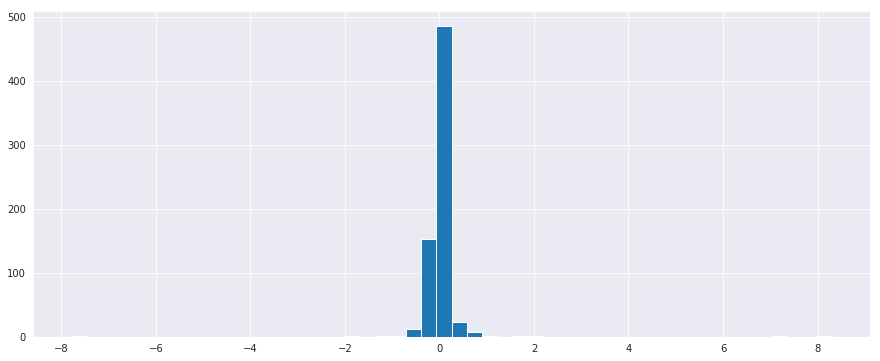

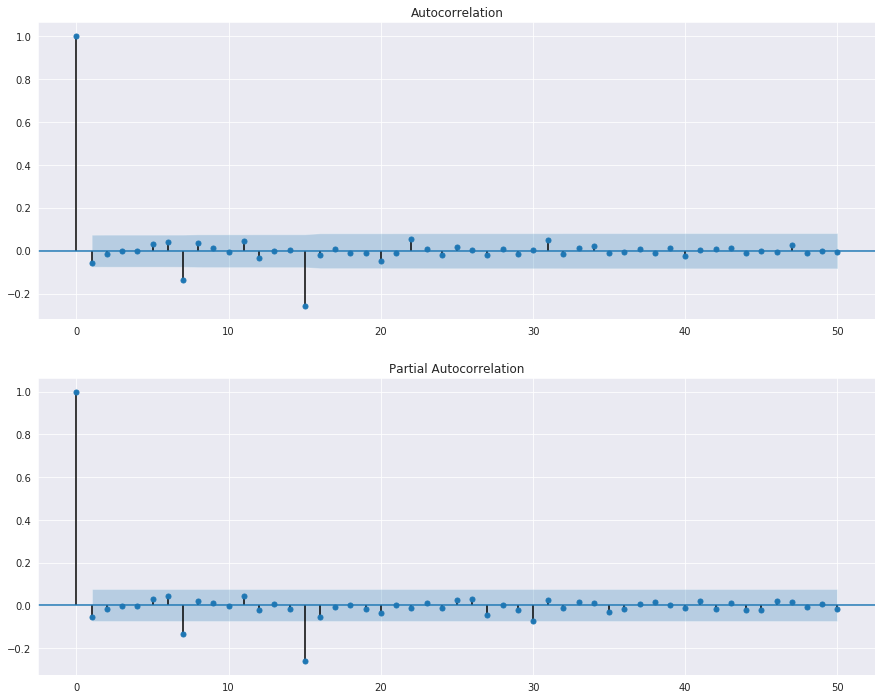

In [388]:
df_merged['delent_diff2'] = df_merged['delent_diff1'].diff()
make_ts_plots(drop_inf_na(df_merged['delent_diff2']))

### Cab Rides
#### lag = 7

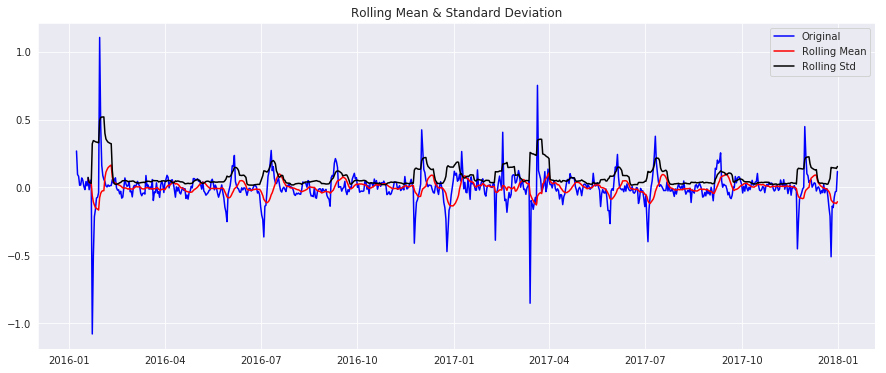

Results of Dickey-Fuller Test:
Test Statistic                -1.002363e+01
p-value                        1.653932e-17
#Lags Used                     2.000000e+01
Number of Observations Used    7.030000e+02
Critical Value (1%)           -3.439686e+00
Critical Value (5%)           -2.865660e+00
Critical Value (10%)          -2.568964e+00
dtype: float64


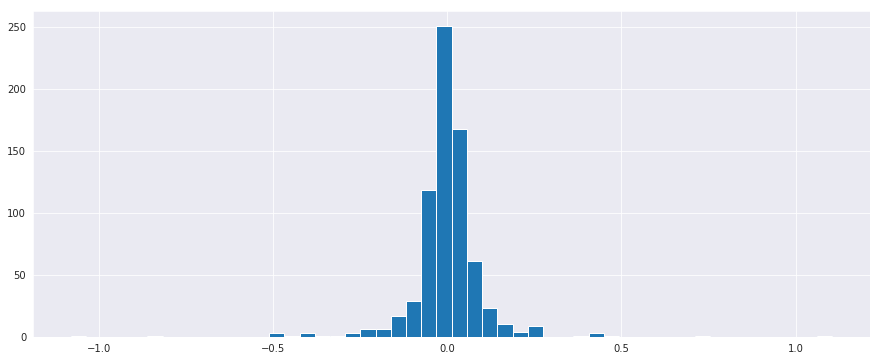

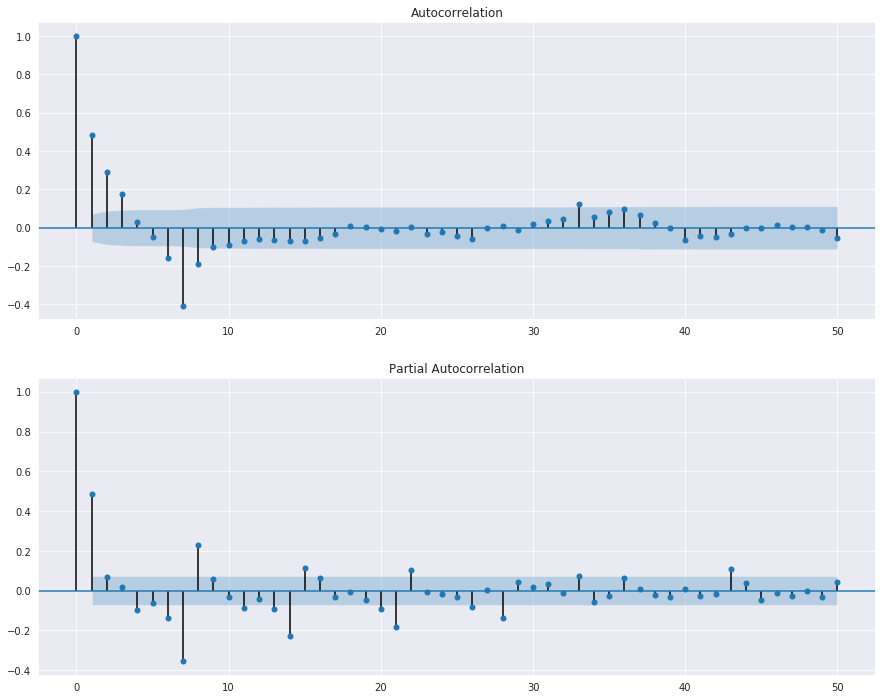

In [389]:
df_merged['cabs_diff1'] = smooth_log_diff(df_merged['passengers'], lag=7)
make_ts_plots(drop_inf_na(df_merged['cabs_diff1']))

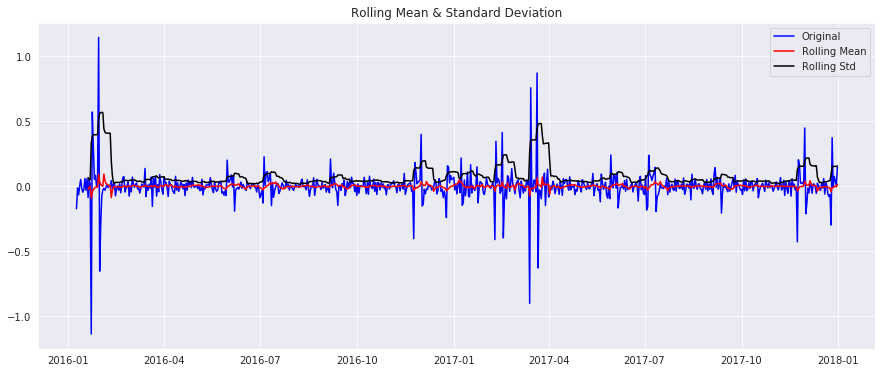

Results of Dickey-Fuller Test:
Test Statistic                -1.067419e+01
p-value                        4.093813e-19
#Lags Used                     2.000000e+01
Number of Observations Used    7.020000e+02
Critical Value (1%)           -3.439700e+00
Critical Value (5%)           -2.865666e+00
Critical Value (10%)          -2.568967e+00
dtype: float64


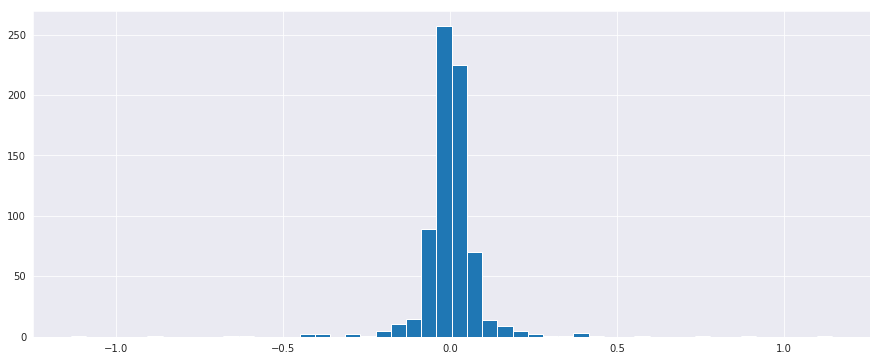

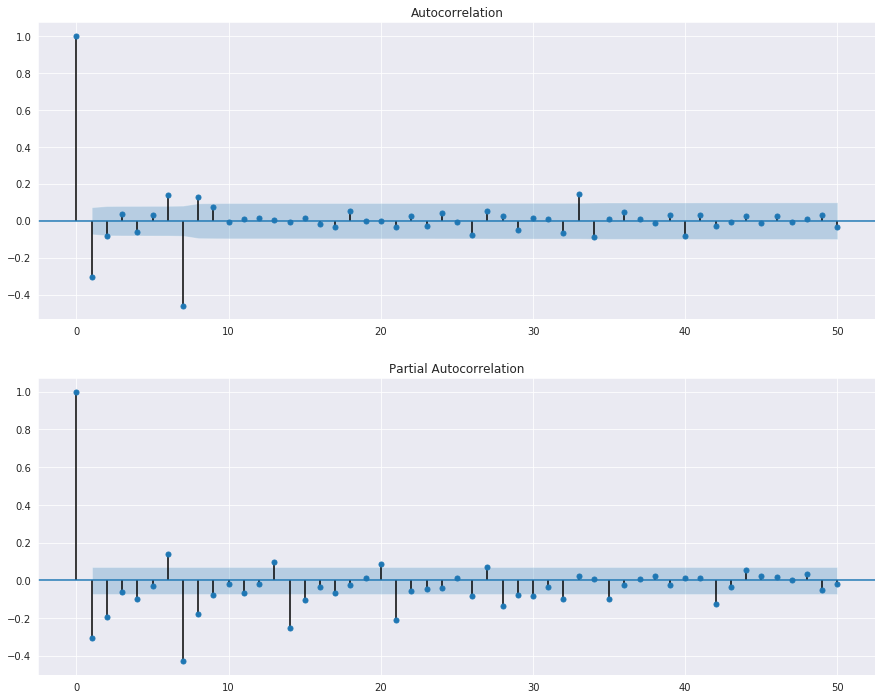

In [390]:
df_merged['cabs_diff2'] = df_merged['cabs_diff1'].diff()
make_ts_plots(drop_inf_na(df_merged['cabs_diff2']))

### Traffic Speed
#### lag = 7

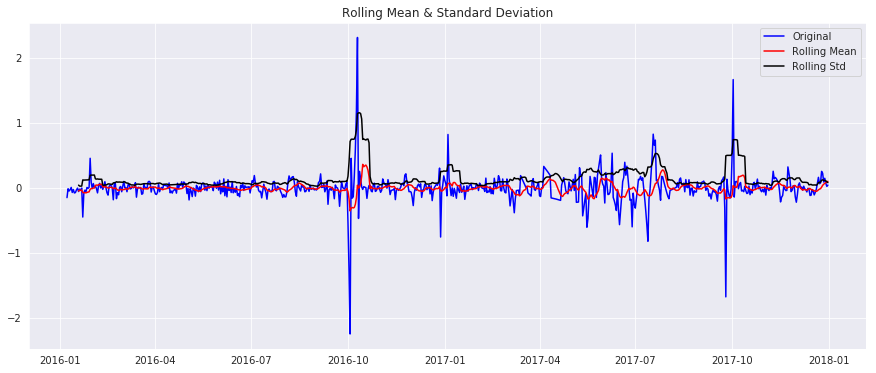

Results of Dickey-Fuller Test:
Test Statistic                -9.588275e+00
p-value                        2.068878e-16
#Lags Used                     2.000000e+01
Number of Observations Used    7.030000e+02
Critical Value (1%)           -3.439686e+00
Critical Value (5%)           -2.865660e+00
Critical Value (10%)          -2.568964e+00
dtype: float64


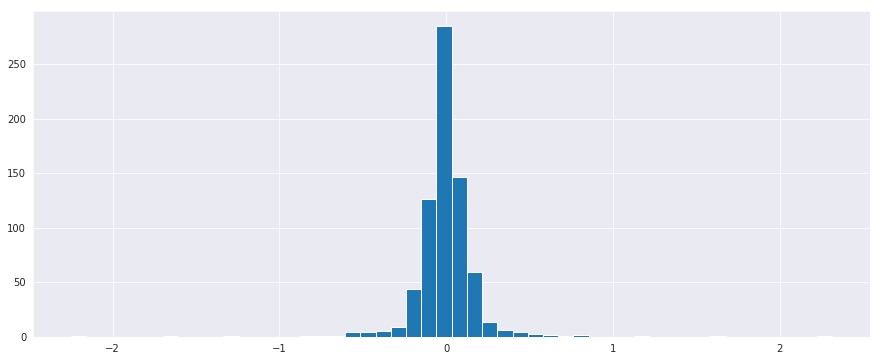

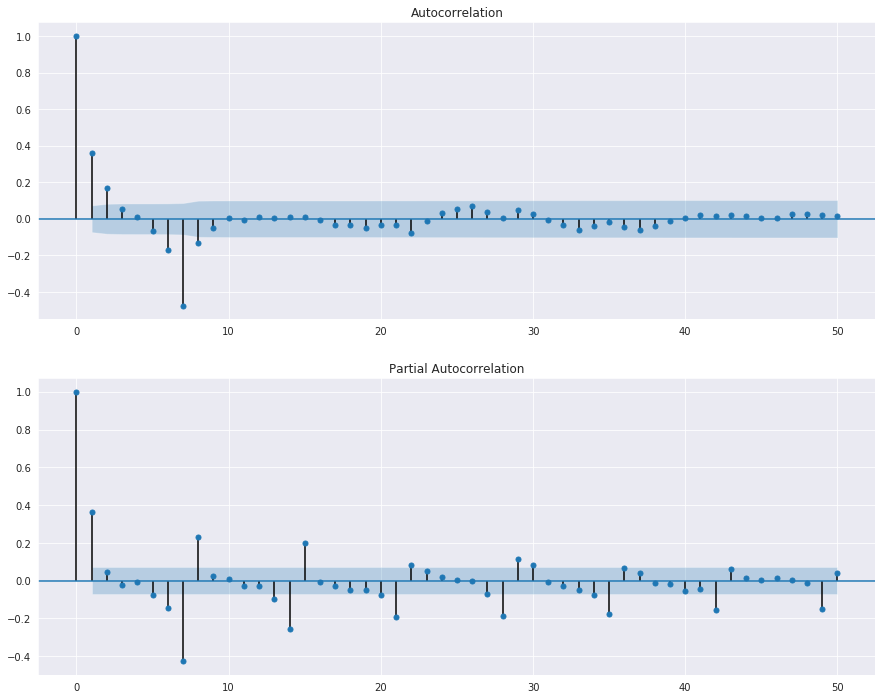

In [391]:
df_merged['traffic_diff1'] = smooth_log_diff(df_merged['speed'], lag=7)
make_ts_plots(drop_inf_na(df_merged['traffic_diff1']))

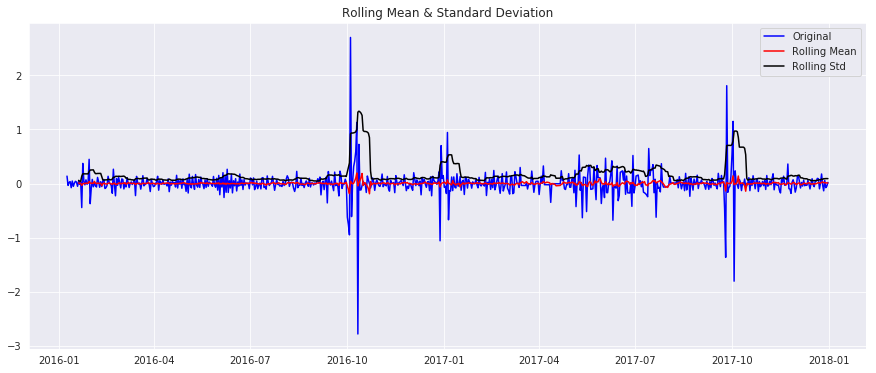

Results of Dickey-Fuller Test:
Test Statistic                -1.020813e+01
p-value                        5.732174e-18
#Lags Used                     2.000000e+01
Number of Observations Used    7.020000e+02
Critical Value (1%)           -3.439700e+00
Critical Value (5%)           -2.865666e+00
Critical Value (10%)          -2.568967e+00
dtype: float64


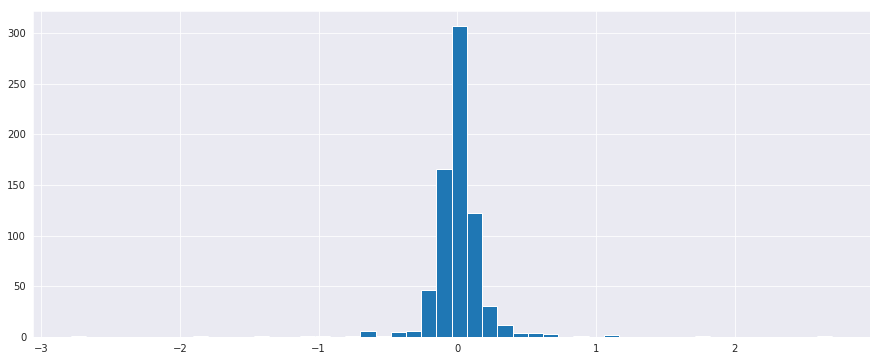

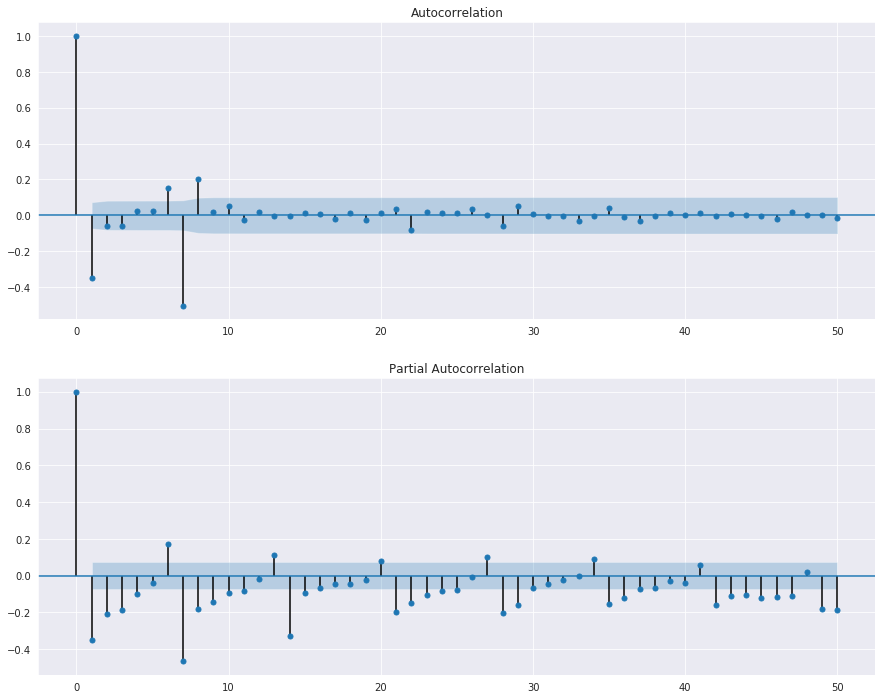

In [392]:
df_merged['traffic_diff2'] = df_merged['traffic_diff1'].diff()
make_ts_plots(drop_inf_na(df_merged['traffic_diff2']))

### Gas Price

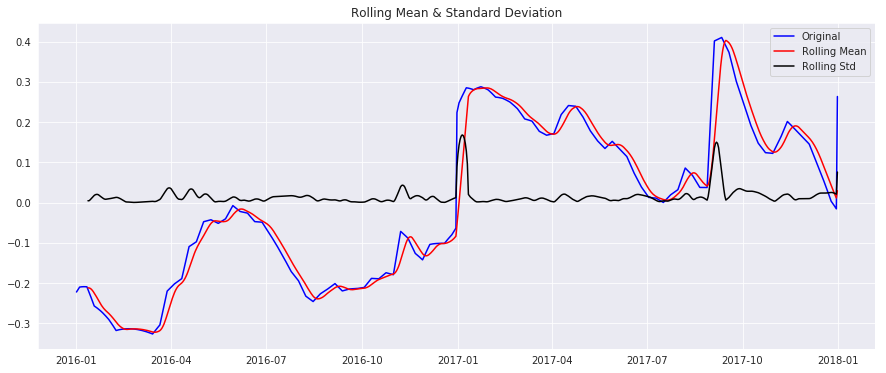

Results of Dickey-Fuller Test:
Test Statistic                  -1.354154
p-value                          0.604048
#Lags Used                       3.000000
Number of Observations Used    727.000000
Critical Value (1%)             -3.439377
Critical Value (5%)             -2.865524
Critical Value (10%)            -2.568891
dtype: float64


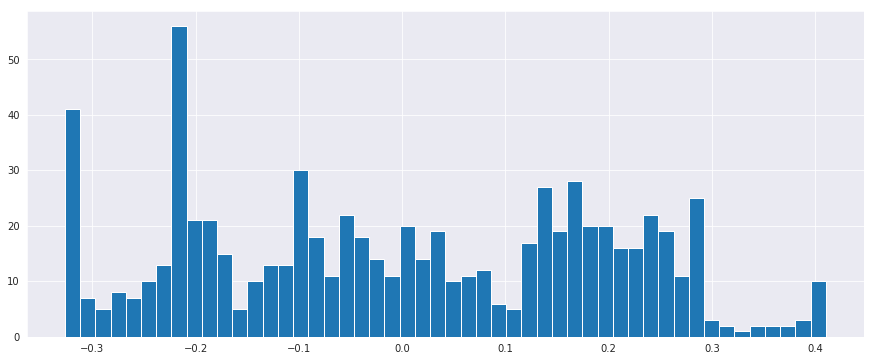

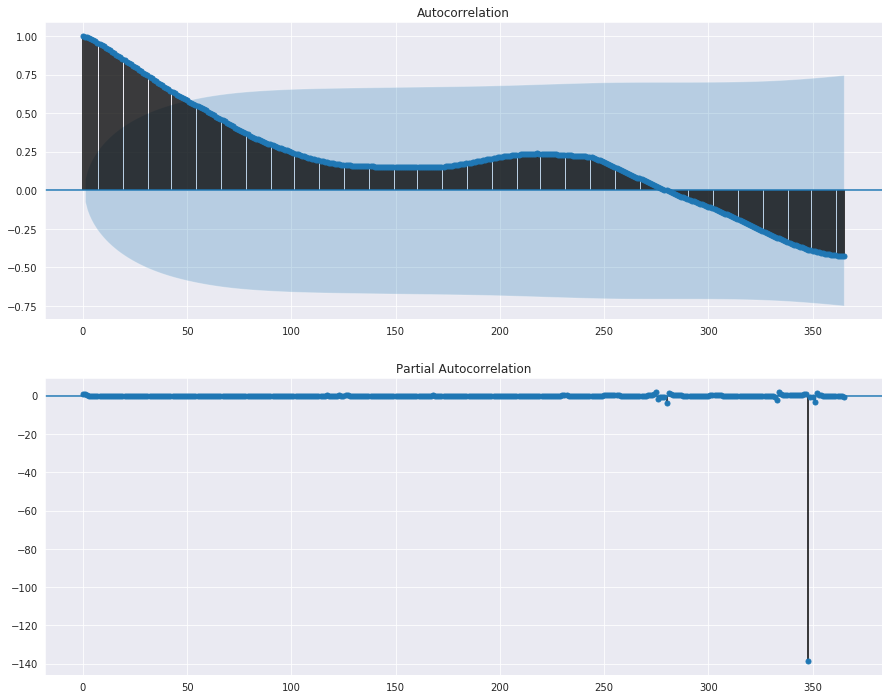

In [393]:
df_merged['gas_diff1'] = smooth_poly(df_merged['price'], degree=4)
make_ts_plots(drop_inf_na(df_merged['gas_diff1']), lag=365)

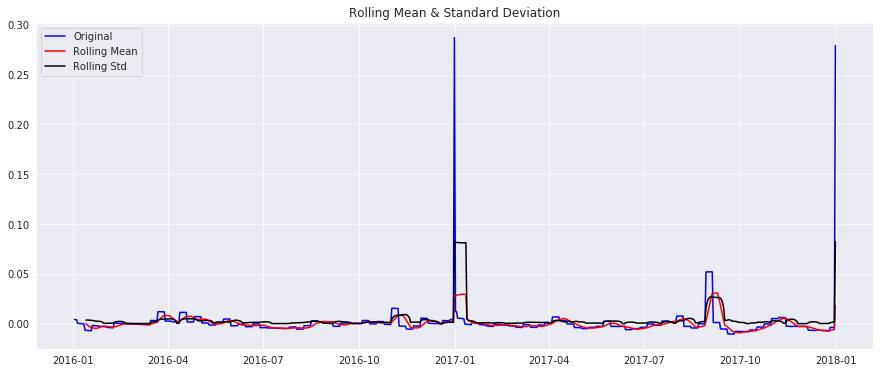

Results of Dickey-Fuller Test:
Test Statistic                -8.299542e+00
p-value                        4.053340e-13
#Lags Used                     2.000000e+00
Number of Observations Used    7.270000e+02
Critical Value (1%)           -3.439377e+00
Critical Value (5%)           -2.865524e+00
Critical Value (10%)          -2.568891e+00
dtype: float64


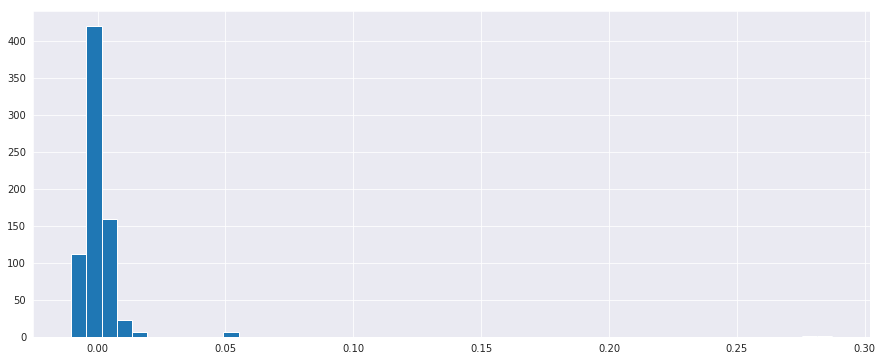

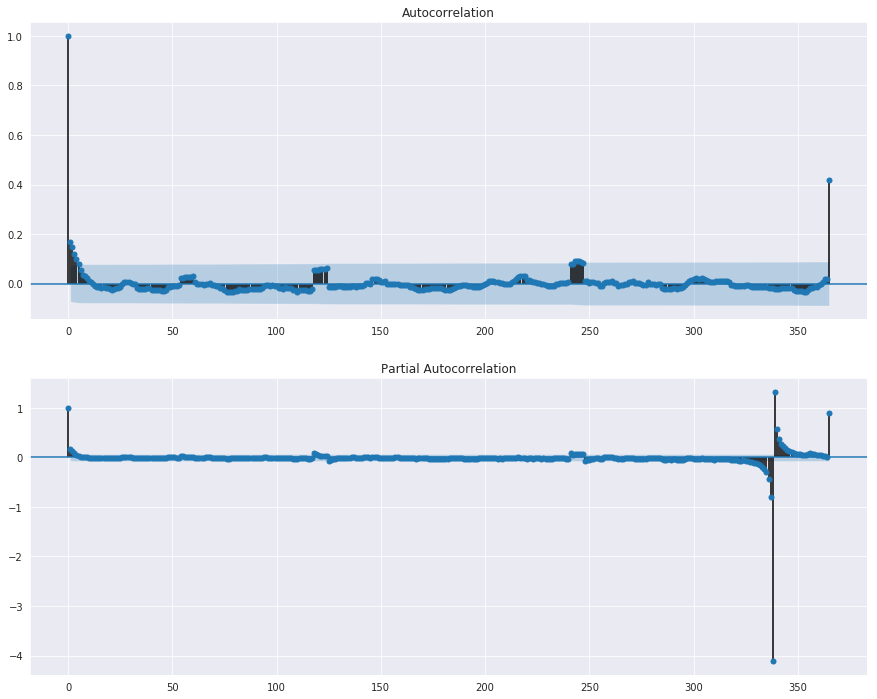

In [394]:
df_merged['gas_diff2'] = df_merged['gas_diff1'].diff()
make_ts_plots(drop_inf_na(df_merged['gas_diff2']), lag=365)

### Weather Temperature

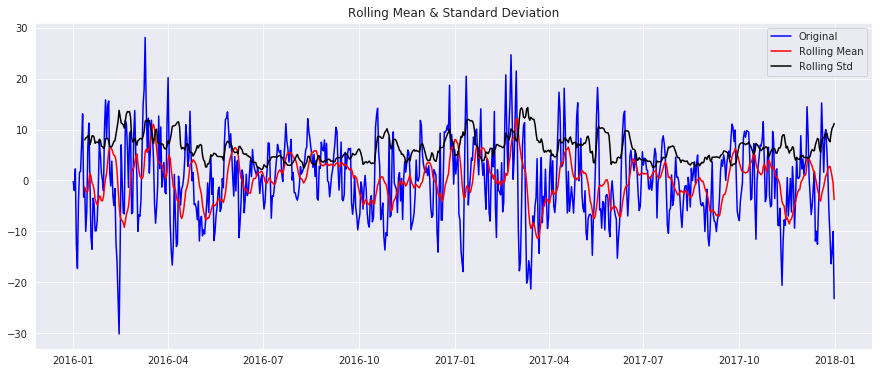

Results of Dickey-Fuller Test:
Test Statistic                -1.048329e+01
p-value                        1.198180e-18
#Lags Used                     2.000000e+00
Number of Observations Used    7.280000e+02
Critical Value (1%)           -3.439364e+00
Critical Value (5%)           -2.865518e+00
Critical Value (10%)          -2.568888e+00
dtype: float64


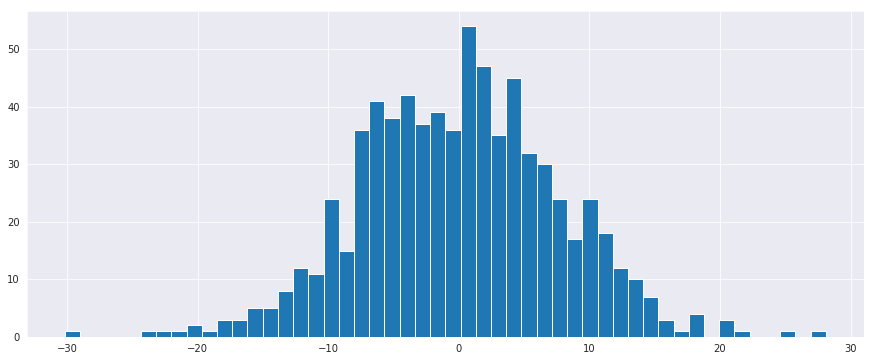

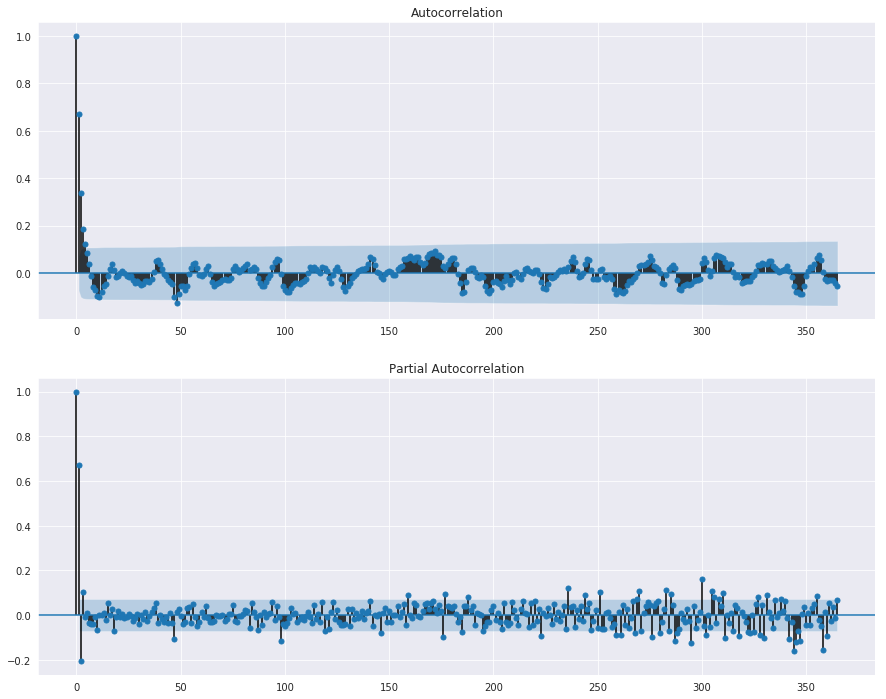

In [395]:
df_merged['weather_diff1'] = smooth_poly(df_merged['temp'], degree=4)
make_ts_plots(drop_inf_na(df_merged['weather_diff1']), lag=365)

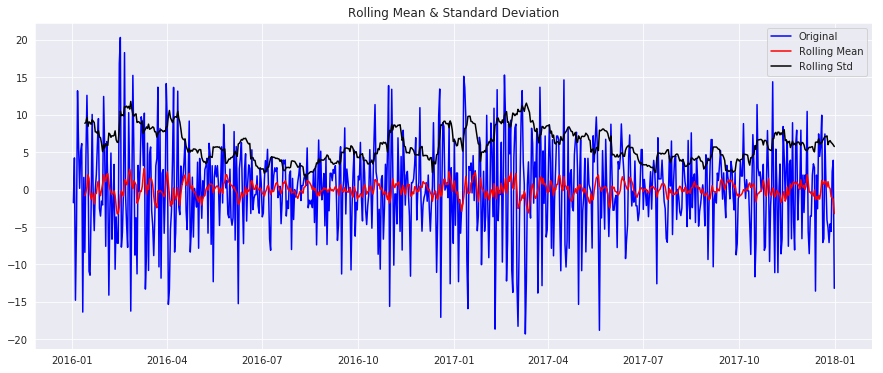

Results of Dickey-Fuller Test:
Test Statistic                -1.137554e+01
p-value                        8.764494e-21
#Lags Used                     1.500000e+01
Number of Observations Used    7.140000e+02
Critical Value (1%)           -3.439542e+00
Critical Value (5%)           -2.865596e+00
Critical Value (10%)          -2.568930e+00
dtype: float64


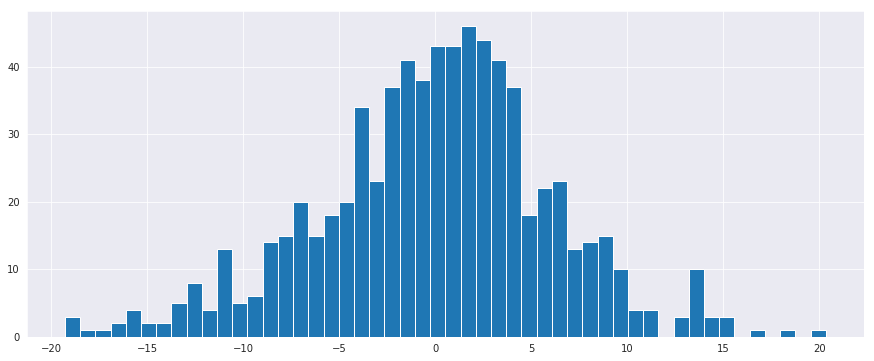

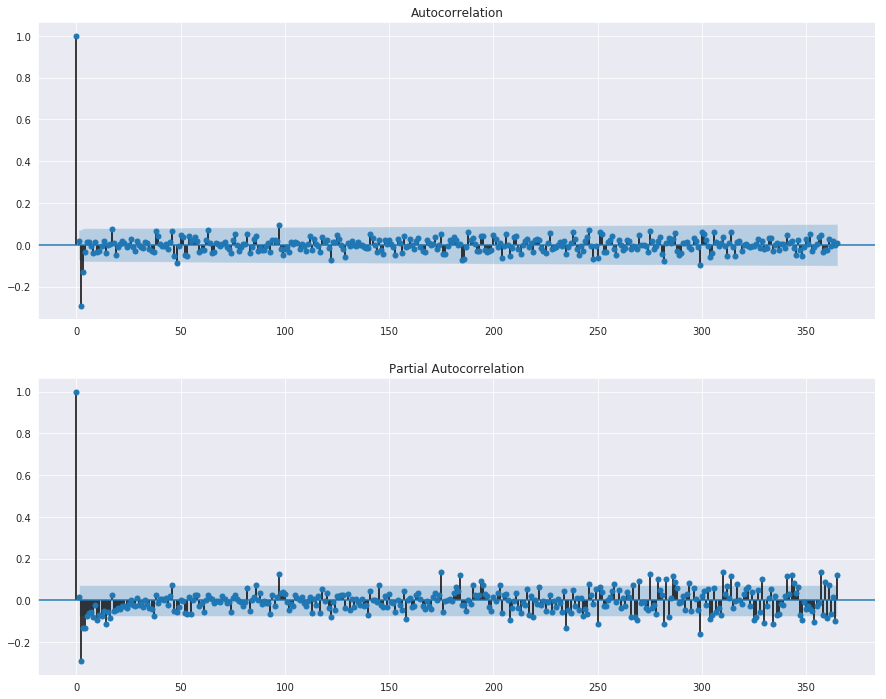

In [396]:
df_merged['weather_diff2'] = df_merged['weather_diff1'].diff()
make_ts_plots(drop_inf_na(df_merged['weather_diff2']), lag=365)

In [397]:
df_merged.head(20)

,delex,delent,passengers,distance,speed,traveltime,price,prcp,snow,temp,...,delent_diff1,delent_diff2,cabs_diff1,cabs_diff2,traffic_diff1,traffic_diff2,gas_diff1,gas_diff2,weather_diff1,weather_diff2
2016-01-01,3059.0,3133.0,44.589850,98.551459,46.992075,140.999960,2.147000,0.00,0.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.222370,NaN,-0.220449,NaN
2016-01-02,2980.0,2780.0,52.132504,110.969024,44.709208,155.253829,2.147000,0.00,0.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.218175,0.004194,-1.970022,-1.749573
2016-01-03,2374.0,3051.0,48.275369,113.245013,45.518173,155.956252,2.147000,0.00,0.0,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.214098,0.004077,2.267723,4.237745
2016-01-04,2353.0,3017.0,54.961410,2079.296367,40.980257,181.892347,2.147000,0.00,0.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.210137,0.003961,-12.507054,-14.774777
2016-01-05,2093.0,3020.0,55.995345,229.976845,40.434037,189.558958,2.143571,0.00,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.209719,0.000418,-17.294192,-4.787138
2016-01-06,2506.0,3348.0,56.503925,111.122529,40.218208,195.032905,2.140143,0.00,0.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.209414,0.000305,-4.093532,13.200660
2016-01-07,2511.0,3236.0,56.316568,113.395173,39.408069,204.966896,2.136714,0.00,0.0,38.5,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.209221,0.000193,1.595085,5.688617
2016-01-08,2843.0,3525.0,58.296028,115.261554,40.469035,195.262932,2.133286,0.00,0.0,38.5,...,0.117889,NaN,0.268028,NaN,-0.149442,NaN,-0.209138,0.000083,1.771817,0.176732
2016-01-09,3053.0,2666.0,57.336977,111.694510,44.136461,159.812349,2.129857,0.00,0.0,43.5,...,-0.041872,-0.159761,0.095157,-0.172871,-0.012893,0.136549,-0.209163,-0.000026,6.936820,5.165004
2016-01-10,2464.0,3318.0,52.399841,116.109344,43.402632,156.764702,2.126429,1.80,0.0,49.5,...,0.083893,0.125764,0.081982,-0.013175,-0.047592,-0.034698,-0.209297,-0.000133,13.090252,6.153432


### Train-Test Split

In [398]:
def interpolate_inf_na(df):
    df = df.replace([inf, -inf], nan).interpolate('time', limit_direction='both')
    return df    

In [399]:
df_merged = interpolate_inf_na(df_merged)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 22 columns):
delex            731 non-null float64
delent           731 non-null float64
passengers       731 non-null float64
distance         731 non-null float64
speed            731 non-null float64
traveltime       731 non-null float64
price            731 non-null float64
prcp             731 non-null float64
snow             731 non-null float64
temp             731 non-null float64
delex_diff1      731 non-null float64
delex_diff2      731 non-null float64
delent_diff1     731 non-null float64
delent_diff2     731 non-null float64
cabs_diff1       731 non-null float64
cabs_diff2       731 non-null float64
traffic_diff1    731 non-null float64
traffic_diff2    731 non-null float64
gas_diff1        731 non-null float64
gas_diff2        731 non-null float64
weather_diff1    731 non-null float64
weather_diff2    731 non-null float64
dtypes: float64(22)
memory usage

In [400]:
train = df_merged.loc[:'2017-06-30'][['delex_diff2','delent_diff2', 'cabs_diff2', 'traffic_diff2', 'gas_diff2', 'weather_diff2']]
test = df_merged.loc['2017-07-01':][['delex_diff2','delent_diff2', 'cabs_diff2', 'traffic_diff2', 'gas_diff2', 'weather_diff2']]

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2016-01-01 to 2017-06-30
Freq: D
Data columns (total 6 columns):
delex_diff2      547 non-null float64
delent_diff2     547 non-null float64
cabs_diff2       547 non-null float64
traffic_diff2    547 non-null float64
gas_diff2        547 non-null float64
weather_diff2    547 non-null float64
dtypes: float64(6)
memory usage: 29.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2017-07-01 to 2017-12-31
Freq: D
Data columns (total 6 columns):
delex_diff2      184 non-null float64
delent_diff2     184 non-null float64
cabs_diff2       184 non-null float64
traffic_diff2    184 non-null float64
gas_diff2        184 non-null float64
weather_diff2    184 non-null float64
dtypes: float64(6)
memory usage: 10.1 KB


In [401]:
train_y = train[['delex_diff2','delent_diff2']]
train_x = train[['cabs_diff2', 'traffic_diff2', 'gas_diff2', 'weather_diff2']]
test_y = test[['delex_diff2','delent_diff2']]
test_x = test[['cabs_diff2', 'traffic_diff2', 'gas_diff2', 'weather_diff2']]

### Applying VAR Model

In [402]:
def make_var_plots(var_result, index=0):
    #fig, ax = plt.subplots(figsize=(15,12))
    var_result.plot_diagnostics(variable=index, figsize=(15,12))
    return

In [403]:
from statsmodels.tsa.statespace.varmax import VARMAX

### Model Selection

In [404]:
from numpy import zeros
p_max = 5
q_max =5
aic = DataFrame(zeros((p_max,q_max), dtype=float))
bic = DataFrame(zeros((p_max,q_max), dtype=float))
for p in range(1,p_max+1):
    for q in range(1,q_max+1):
        var_model = VARMAX(train_y, train_x, order=(p,q), trend='c')
        var_model_result = var_model.fit(maxiter=1000, disp=False)
        #print('order = {:d},{:d}'.format(p,q))
        aic.iloc[p-1,q-1] = var_model_result.aic
        bic.iloc[p-1,q-1] = var_model_result.bic
        #print('aic = ',var_model_result.aic)
        #print('bic = ',var_model_result.bic)
        #print('hqic = ',var_model_result.hqic)

In [405]:
q = aic.min().idxmin()
p = aic.idxmin()[q]
print('optimum order = {:d},{:d}'.format(p,q))

optimum order = 4,4


In [406]:
var_model = VARMAX(train_y, train_x, order=(p,q), trend='c')
var_model_result = var_model.fit(maxiter=1000, disp=False)
print(var_model_result.summary())

                                  Statespace Model Results                                 
Dep. Variable:     ['delex_diff2', 'delent_diff2']   No. Observations:                  547
Model:                                 VARMAX(4,4)   Log Likelihood                -803.901
                                       + intercept   AIC                           1697.802
Date:                             Mon, 19 Nov 2018   BIC                           1891.502
Time:                                     07:10:12   HQIC                          1773.515
Sample:                                 01-01-2016                                         
                                      - 06-30-2017                                         
Covariance Type:                               opg                                         
Ljung-Box (Q):              113.50, 106.25   Jarque-Bera (JB):   28518.90, 32385.51
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Hete

### Transit Passengers (exiting the station)

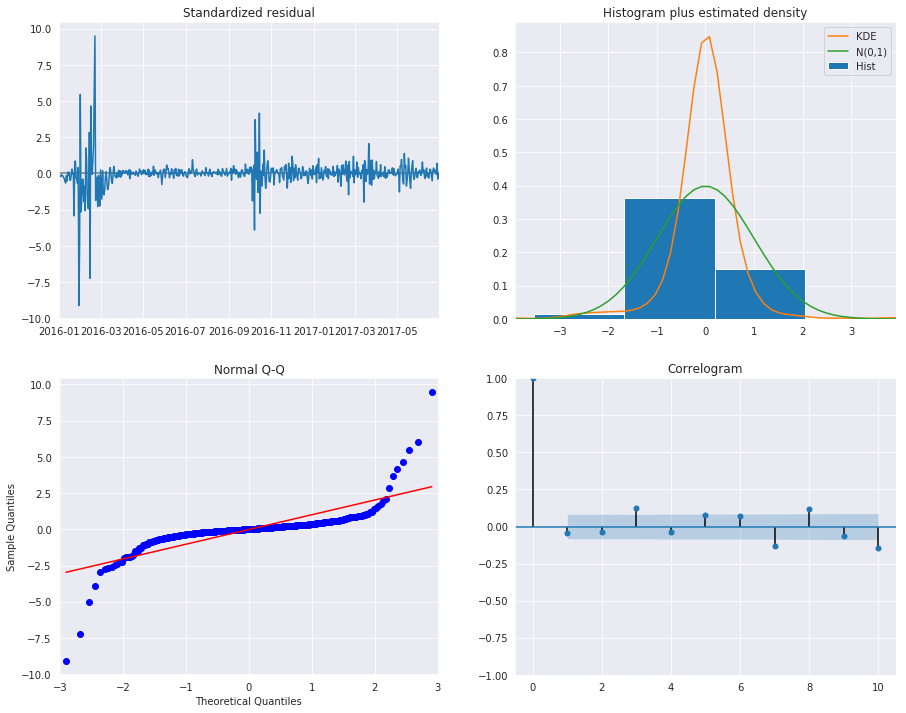

In [407]:
make_var_plots(var_model_result, index=0)

### Transit Passengers (entering the station)

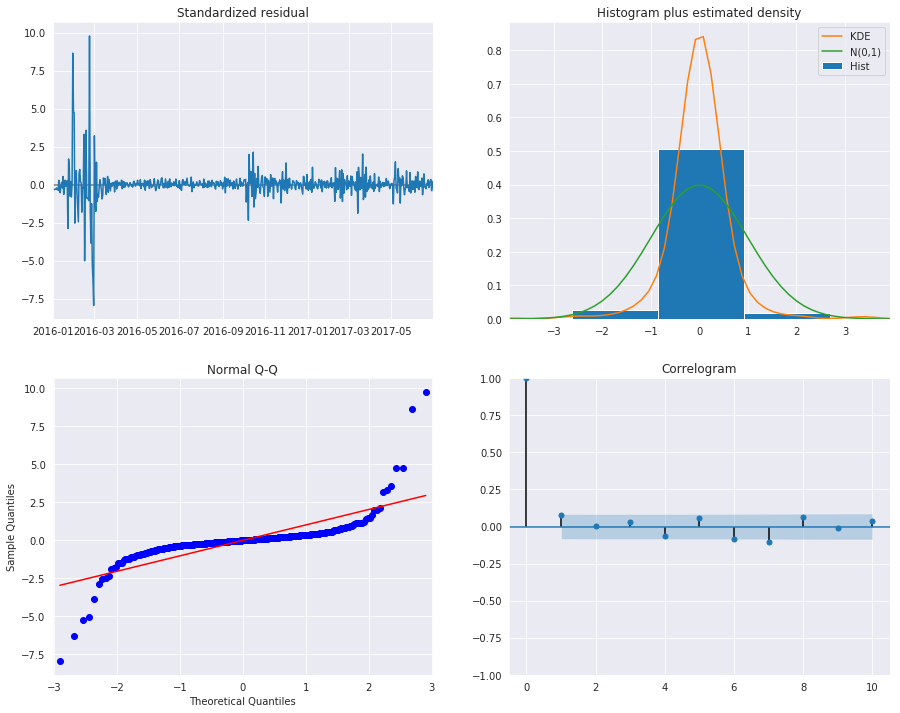

In [408]:
make_var_plots(var_model_result, index=1)

### Inverse Tranform
#### (Inverting the second-order difference transformation to retrieve predicted values in the original form)

$$\ddot y_t = \dot y_t - \dot y_{t-lag_2}$$
$$\dot y_t = \ddot y_t + \dot y_{t-lag_2}$$

$$\dot y_t = \log{y_t} - \log{y_{t-lag_1}} = \log{\frac{y_t}{y_{t-lag_1}}}$$
$$e^{\dot y_t} = \frac{y_t}{y_{t-lag_1}}$$
$$y_t = y_{t-lag_1} e^{\dot y_t} 
      = y_{t-lag_1} e^{\ddot y_t + \dot y_{t-lag_2}} 
      = y_{t-lag_1} e^{\ddot y_t} e^{\dot y_{t-lag_2}} 
      = y_{t-lag_1} e^{\ddot y_t} e^{\log{\frac{y_{t-lag_2}}{y_{t-lag_2-lag_1}}}} 
      = \frac{y_{t-lag_1}y_{t-lag_2}}{y_{t-lag_2-lag_1}} e^{\ddot y_t}$$

In [452]:
from numpy import exp
from pandas import Timedelta, to_datetime
# y_hat_transformed and y must have the same number of columns 
# (each column in y corresponding to a transformed column in y_hat_transformed)
# length and row-index of y_hat is same as length and row-index of y_hat_transformed
# first (lag1+lag2) number of rows of y_hat has same values as first (lag1+lag2) number of rows of y
def inverse_transform(y_hat_transformed, y, lag_1, lag_2):
    y_hat = DataFrame(index=y_hat_transformed.index, columns=y.columns)
    td_1 = Timedelta(lag_1, unit='d')
    td_2 = Timedelta(lag_2, unit='d')
    idx0 = y_hat.index.to_series().iloc[0]
    print('start date ', idx0)
    initial_idx = (idx0+td_1+td_2).strftime('%Y-%m-%d')
    print('start date +lag1+lag2 ', initial_idx)
    for col in y_hat.columns:
        col_idx = y_hat.columns.get_loc(col)
        #for i, idx in enumerate(y_hat.index.values): 
        #    if i < lag_1+lag_2:
        y_hat[col].loc[:initial_idx] = y[col].loc[:initial_idx]
        df = DataFrame(index=y_hat.index)
        df['orig'] = y_hat[col]
        df['lag_1'] = y_hat[col].shift(freq=td_1)
        df['lag_2'] = y_hat[col].shift(freq=td_2)
        df['lag_1+lag_2'] = y_hat[col].shift(freq=td_1+td_2)
        print(col)
        print(df.head(10))
        #    else:
        y_hat[col].loc[initial_idx:] = exp(y_hat_transformed.iloc[:,col_idx].loc[initial_idx:]) *\
                                       y_hat[col].shift(freq=td_1).loc[initial_idx:] *\
                                       y_hat[col].shift(freq=td_2).loc[initial_idx:] /\
                                       y_hat[col].shift(freq=td_1+td_2).loc[initial_idx:]
    return y_hat

### Forecasting

In [410]:
# Generate Exogenous Data for Forecasting
nforecast = len(test_x)
print('no. of training observations ',var_model_result.nobs)
print('no. of data-points to be forecast ',nforecast)

no. of training observations  547
no. of data-points to be forecast  184


In [411]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
predict = var_model_result.get_prediction(end=var_model_result.nobs + nforecast-1, exog = test_x)
""" idx = np.arange(len(predict.predicted_mean)) """
predict_ci95 = predict.conf_int(alpha=0.05)
predict_ci60 = predict.conf_int(alpha=0.4)
predict_ci30 = predict.conf_int(alpha=0.7)

In [414]:
def make_prediction_plot(df, train_y, test_y, predict, predict_ci95, predict_ci60, predict_ci30, y_hat_column, y_column, inverse_trans_func=None):
    train_y = df.loc[train_y.index][[y_column]]
    test_y = df.loc[test_y.index][[y_column]]
    pred_mean = predict.predicted_mean[[y_hat_column]]
    df = concat([train_y, test_y])
    idx = df.index
    #fidx = predict_ci95.index
    lower = 'lower '+y_hat_column
    upper = 'upper '+y_hat_column
    predict_ci95_lower = predict_ci95[[lower]].rename(columns={lower: y_hat_column})
    predict_ci95_upper = predict_ci95[[upper]].rename(columns={upper: y_hat_column})
    predict_ci60_lower = predict_ci60[[lower]].rename(columns={lower: y_hat_column})
    predict_ci60_upper = predict_ci60[[upper]].rename(columns={upper: y_hat_column})
    predict_ci30_lower = predict_ci30[[lower]].rename(columns={lower: y_hat_column})
    predict_ci30_upper = predict_ci30[[upper]].rename(columns={upper: y_hat_column})
    if inverse_trans_func is not None:
        lag_1=7
        lag_2=1
        pred_mean = inverse_trans_func(pred_mean, train_y, lag_1, lag_2)
        #predict_ci95_lower = inverse_trans_func(predict_ci95_lower, train_y, lag_1, lag_2)
        #predict_ci95_upper = inverse_trans_func(predict_ci95_upper, train_y, lag_1, lag_2)
        #predict_ci60_lower = inverse_trans_func(predict_ci60_lower, train_y, lag_1, lag_2)
        #predict_ci60_upper = inverse_trans_func(predict_ci60_upper, train_y, lag_1, lag_2)
        #predict_ci30_lower = inverse_trans_func(predict_ci30_lower, train_y, lag_1, lag_2)
        #predict_ci30_upper = inverse_trans_func(predict_ci30_upper, train_y, lag_1, lag_2)
    #forecast_var_idx = pred_mean.columns.get_loc(y_hat_column)
    #ci_lower_idx = forecast_var_idx
    #ci_upper_idx = forecast_var_idx+len(pred_mean.columns)
    # Graph
    fig, ax = plt.subplots(figsize=(18,18))
    ax.grid()
    ax.plot(idx,df,'k',label='', alpha=0.7, linewidth=0.75)
    ax.plot(idx,df,'k.', label='Actual Values', alpha=0.7, linewidth=0.75)
    # Plot
    ax.plot(train_y.index, pred_mean[:-nforecast], color='blue',label='Train-Set Prediction')
    ax.plot(test_y.index, pred_mean[-nforecast:], 'k--', color='red', linestyle='--', linewidth=1.5,label='Test-Set Prediction')
    
    if inverse_trans_func is None:
        ax.fill_between(test_y.index, predict_ci95_lower.iloc[-nforecast:,0], 
                        predict_ci95_upper.iloc[-nforecast:,0], alpha=0.15, label= '')
        ax.fill_between(test_y.index, predict_ci60_lower.iloc[-nforecast:,0], 
                        predict_ci60_upper.iloc[-nforecast:,0], alpha=0.15, label= '')
        ax.fill_between(test_y.index, predict_ci30_lower.iloc[-nforecast:,0], 
                        predict_ci30_upper.iloc[-nforecast:,0], alpha=0.15, label= '')
    ax.legend()
    ax.set(title='VARMAX - Forecasting');
    plt.show(fig)

In [423]:
pred_mean = predict.predicted_mean
pred_mean.head()

,delex_diff2,delent_diff2
2016-01-01,0.254946,0.073599
2016-01-02,0.194437,-0.011259
2016-01-03,0.194238,0.009409
2016-01-04,0.241909,0.024029
2016-01-05,0.153515,-0.013941


In [424]:
df_merged.loc[train_y.index].head()

,delex,delent,passengers,distance,speed,traveltime,price,prcp,snow,temp,...,delent_diff1,delent_diff2,cabs_diff1,cabs_diff2,traffic_diff1,traffic_diff2,gas_diff1,gas_diff2,weather_diff1,weather_diff2
2016-01-01,3059.0,3133.0,44.589850,98.551459,46.992075,140.999960,2.147000,0.0,0.0,38.0,...,0.117889,-0.159761,0.268028,-0.172871,-0.149442,0.136549,-0.222370,0.004194,-0.220449,-1.749573
2016-01-02,2980.0,2780.0,52.132504,110.969024,44.709208,155.253829,2.147000,0.0,0.0,36.0,...,0.117889,-0.159761,0.268028,-0.172871,-0.149442,0.136549,-0.218175,0.004194,-1.970022,-1.749573
2016-01-03,2374.0,3051.0,48.275369,113.245013,45.518173,155.956252,2.147000,0.0,0.0,40.0,...,0.117889,-0.159761,0.268028,-0.172871,-0.149442,0.136549,-0.214098,0.004077,2.267723,4.237745
2016-01-04,2353.0,3017.0,54.961410,2079.296367,40.980257,181.892347,2.147000,0.0,0.0,25.0,...,0.117889,-0.159761,0.268028,-0.172871,-0.149442,0.136549,-0.210137,0.003961,-12.507054,-14.774777
2016-01-05,2093.0,3020.0,55.995345,229.976845,40.434037,189.558958,2.143571,0.0,0.0,20.0,...,0.117889,-0.159761,0.268028,-0.172871,-0.149442,0.136549,-0.209719,0.000418,-17.294192,-4.787138


In [453]:
pred_mean = inverse_transform(pred_mean, df_merged.loc[train_y.index], lag_1=7, lag_2=1)
pred_mean.info()

start date  2016-01-01 00:00:00
start date +lag1+lag2  2016-01-09
delex
            orig lag_1 lag_2 lag_1+lag_2
2016-01-01  3059   NaN   NaN         NaN
2016-01-02  2980   NaN  3059         NaN
2016-01-03  2374   NaN  2980         NaN
2016-01-04  2353   NaN  2374         NaN
2016-01-05  2093   NaN  2353         NaN
2016-01-06  2506   NaN  2093         NaN
2016-01-07  2511   NaN  2506         NaN
2016-01-08  2843  3059  2511         NaN
2016-01-09  3053  2980  2843        3059
2016-01-10   NaN  2374  3053        2980
delent
            orig lag_1 lag_2 lag_1+lag_2
2016-01-01  3133   NaN   NaN         NaN
2016-01-02  2780   NaN  3133         NaN
2016-01-03  3051   NaN  2780         NaN
2016-01-04  3017   NaN  3051         NaN
2016-01-05  3020   NaN  3017         NaN
2016-01-06  3348   NaN  3020         NaN
2016-01-07  3236   NaN  3348         NaN
2016-01-08  3525  3133  3236         NaN
2016-01-09  2666  2780  3525        3133
2016-01-10   NaN  3051  2666        2780
passengers
        

IndexError: single positional indexer is out-of-bounds

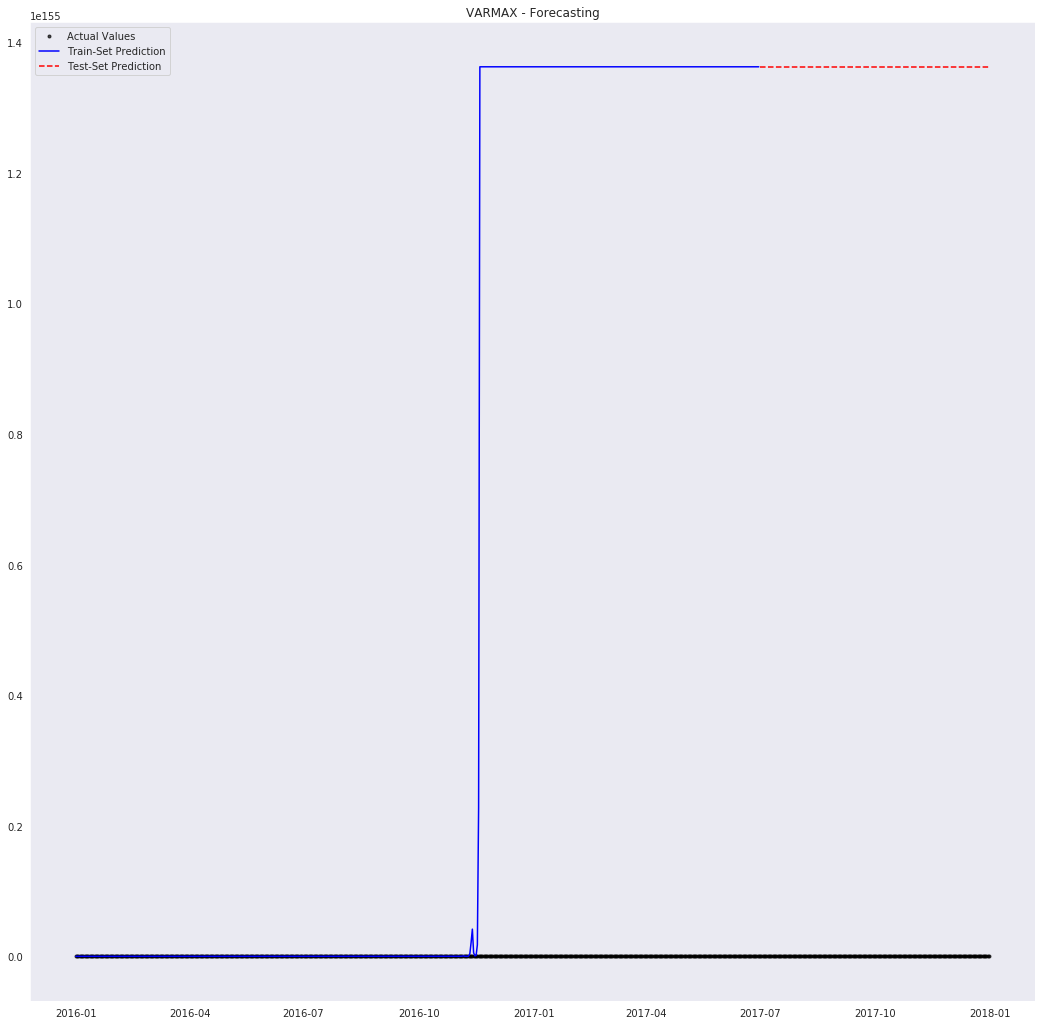

In [419]:
make_prediction_plot(df_merged, train_y, test_y, predict, predict_ci95, predict_ci60, predict_ci30, 'delex_diff2', 'delex', inverse_transform)

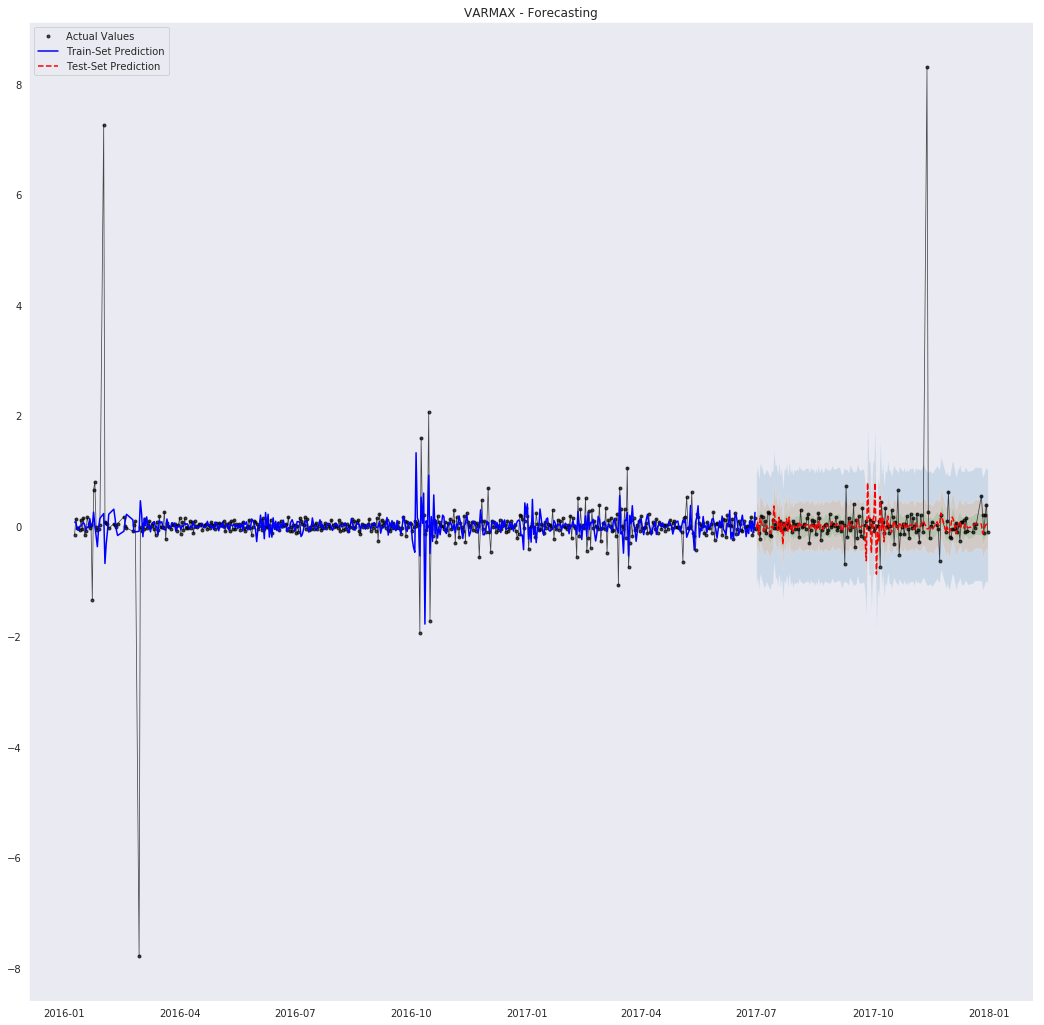

In [269]:
make_prediction_plot(train_y, test_y, predict, predict_ci95, predict_ci60, predict_ci30, 'delent_diff2')

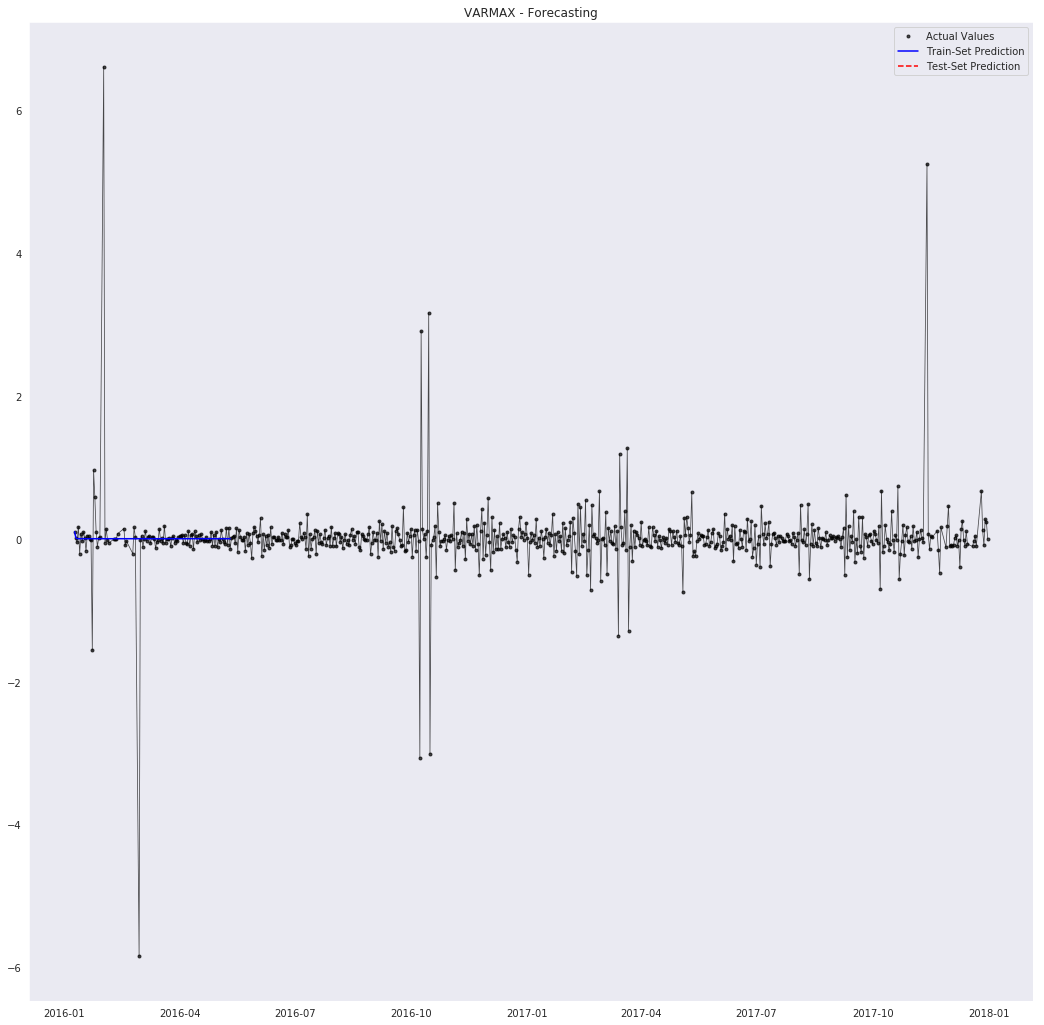

In [272]:
make_prediction_plot(train_y, test_y, predict, predict_ci95, predict_ci60, predict_ci30, 'delex_diff2', inverse_transform)